連線database

In [19]:

import requests
from io import StringIO
import pandas as pd
import time
import json
from json import load
from bs4 import BeautifulSoup
import re

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20200101'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_daily_updown = f"""
SELECT *
FROM daily_updown
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_tif_investors = f"""
SELECT *
FROM daily_tif_investors
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_pc_ratio = f"""
SELECT *
FROM daily_pc_ratio
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tif_investors_df_raw = pd.read_sql(query_tif_investors, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
updown_df_raw = pd.read_sql(query_daily_updown, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)

pc_ratio_raw = pd.read_sql(query_pc_ratio, engine)

twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
twse_df_raw['Date'] = pd.to_datetime(twse_df_raw['Date'])


In [59]:
# 發送 POST 請求
response = requests.post('https://www.tpex.org.tw/www/zh-tw/afterTrading/indexSummary', data='2024-12-12', timeout=10)

# 檢查請求是否成功
if response.status_code == 200:
    # 解析 HTML
    data = json.loads(response.text)

    for table in data["tables"]:
        if table["title"] == "上櫃股價指數收盤行情":
            result = table
            break

    if result:
        # 提取 fields 和 data
        fields = result["fields"]
        rows = result["data"]
        
        # 轉換為 DataFrame
        df = pd.DataFrame(rows, columns=fields)
        
        # 篩選出 "櫃買指數" 的資料
        tpex_df = df[df["指數"] == "櫃買指數"]
        tpex_df = tpex_df.drop(columns=["大盤資訊連結"])
        tpex_df["Date"] = data["date"]  # 加入日期，格式為 YYYYMMDD

        
tpex_df

,指數,收市指數,漲跌,漲跌幅度(%),Date
0,櫃買指數,250.10,-5.19,-2.03,20241216


In [74]:
search_day = '2024/12/16'
url = 'https://www.tpex.org.tw/www/zh-tw/afterTrading/indexSummary?date=' + search_day
response = requests.post(url, timeout=10)
# 檢查請求是否成功
if response.status_code == 200:
    # 解析 HTML
    data = json.loads(response.text)
day.strftime('%Y/%m/%d')

'2024/12/12'

In [103]:
# 短波強勢股
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2021-01-01' ) & (stock_df_raw['Date']<='2024-12-15' ) & (stock_df_raw['證券代號'] == '8028' ) ]['Date']

# 建立一個空的 DataFrame 來存放所有資料
all_tpex_data = pd.DataFrame()

for day in stock_date_list:
    search_day = day.strftime('%Y/%m/%d')
    # 發送 POST 請求
    url = 'https://www.tpex.org.tw/www/zh-tw/afterTrading/indexSummary?date=' + search_day
    response = requests.post(url, timeout=10)

    # 檢查請求是否成功
    if response.status_code == 200:
        # 解析 HTML
        data = json.loads(response.text)

        for table in data["tables"]:
            if table["title"] == "上櫃股價指數收盤行情":
                result = table
                break

        if result:
            # 提取 fields 和 data
            fields = result["fields"]
            rows = result["data"]
            
            # 轉換為 DataFrame
            df = pd.DataFrame(rows, columns=fields)
            
            # 篩選出 "櫃買指數" 的資料
            tpex_df = df[df["指數"] == "櫃買指數"]
            tpex_df = tpex_df.drop(columns=["大盤資訊連結"])
            tpex_df["Date"] = search_day  # 加入日期，格式為 YYYYMMDD

            # 合併資料
            all_tpex_data = pd.concat([all_tpex_data, tpex_df], ignore_index=True)


In [104]:
all_tpex_data.loc[:, '5MA'] = all_tpex_data['收市指數'].rolling(5).mean()
all_tpex_data.loc[:, '8MA'] = all_tpex_data['收市指數'].rolling(8).mean()
all_tpex_data.loc[:, '10MA'] = all_tpex_data['收市指數'].rolling(10).mean()
all_tpex_data.loc[:, '20MA']= all_tpex_data['收市指數'].rolling(20).mean()
all_tpex_data.loc[:, '60MA']= all_tpex_data['收市指數'].rolling(60).mean()
all_tpex_data.loc[:, '240MA']= all_tpex_data['收市指數'].rolling(240).mean()
all_tpex_data

,指數,收市指數,漲跌,漲跌幅度(%),Date,5MA,8MA,10MA,20MA,60MA,240MA
0,櫃買指數,185.80,1.70,0.92,2021/01/04,NaN,NaN,NaN,NaN,NaN,NaN
1,櫃買指數,185.95,0.15,0.08,2021/01/05,NaN,NaN,NaN,NaN,NaN,NaN
2,櫃買指數,184.26,-1.69,-0.91,2021/01/06,NaN,NaN,NaN,NaN,NaN,NaN
3,櫃買指數,186.13,1.87,1.01,2021/01/07,NaN,NaN,NaN,NaN,NaN,NaN
4,櫃買指數,187.02,0.89,0.48,2021/01/08,185.832,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
953,櫃買指數,261.52,-1.87,-0.71,2024/12/06,260.892,258.67500,259.092,258.5500,264.392167,255.596625
954,櫃買指數,260.47,-1.05,-0.40,2024/12/09,261.418,259.30875,258.959,258.2960,264.390167,255.712417
955,櫃買指數,258.21,-2.26,-0.87,2024/12/10,261.238,259.98250,258.808,258.1835,264.427000,255.815917
956,櫃買指數,257.78,-0.43,-0.17,2024/12/11,260.274,260.11500,259.046,258.0710,264.439667,255.915708


In [142]:
tpex_data = all_tpex_data.copy()
# Convert the columns to numeric, forcing any errors to NaN (if any)
tpex_data['收市指數'] = pd.to_numeric(tpex_data['收市指數'], errors='coerce')
# Now perform the comparison
tpex_data['60MA_B'] = tpex_data['收市指數'] < tpex_data['60MA']
tpex_data['240MA_B'] = tpex_data['收市指數'] < tpex_data['240MA']

tpex_data['Date'] = pd.to_datetime(tpex_data['Date'])
# 假設 stock_df_raw 和 tpex_data 都已經載入且包含 'Date' 欄位
merged_data = pd.merge(stock_df_raw, tpex_data, on='Date', how='inner')
# 查看合併後的結果

In [144]:
merged_data[(merged_data['Date']>='2022-01-01' ) & (merged_data['Date']<='2024-12-15' ) & (merged_data['證券代號'] == '8028' )  & (merged_data['240MA_B'])]['Date']

482922    2022-02-24
493498    2022-03-07
495260    2022-03-08
497022    2022-03-09
498784    2022-03-10
             ...    
882092    2023-01-17
1551214   2024-08-05
1553065   2024-08-06
1681156   2024-11-18
1696095   2024-11-28
Name: Date, Length: 215, dtype: datetime64[ns]

In [145]:
# 短波強勢股
stock_date_list = merged_data[(merged_data['Date']>='2022-01-01' ) & (merged_data['Date']<='2024-12-15' ) & (merged_data['證券代號'] == '8028' )  & (merged_data['240MA_B'])]['Date']
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價','明日開盤價','明日收盤價','明日最高價','明日最低價', 'Date'])

pre_day = ""
rs20_rank_his = 100
# 檢查前波高低點差距
backday = 60

for day in stock_date_list:

        if(pre_day == ""):
               pre_day =  day
               continue
        tpex_60MA = tpex_data[tpex_data['Date'] == day.strftime('%Y/%m/%d')]['60MA_B'].iloc[0]
        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day) &  
                                      (stock_df_raw['20RS_rank'] < 90) & 
                                      (stock_df_raw['60RS_rank'] > 95) & 
                                      (stock_df_raw['240RS_rank'] > 98) &  
                                      (stock_df_raw['收盤價'] < stock_df_raw['5MA'])].copy() 
        stock_id_list = stock_df_today['證券代號'].tolist()

        for stock_id in stock_id_list:

                # 查前一天的 20RS_rank
                stock_his_df = stock_df_raw[(stock_df_raw['Date'] == pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                # 會部會遇到剛好原本很弱 停牌隔天爆噴的可能
                if not stock_his_df.empty:
                        rs20_rank_his = stock_his_df['20RS_rank'].iloc[0]
                else:
                        # 停牌的話只能查stock_df_raw往前找了
                        stock_his_df = stock_df_raw[(stock_df_raw['Date'] < pre_day) & (stock_df_raw['證券代號'] == stock_id )]
                        if not stock_his_df.empty:
                                rs20_rank_his = stock_his_df['20RS_rank'].iloc[-1]
                                
                # 過去
                stock_today = stock_df_raw[(stock_df_raw['Date'] == day) & (stock_df_raw['證券代號'] == stock_id )].iloc[0]
                today_close = stock_today['收盤價']
                today_open = stock_today['開盤價']
                stock_name = stock_today['證券名稱']
                stock_volume = stock_today['成交筆數']

                # 明日
                stock_tomo = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]
                if stock_tomo.empty:
                        continue
                stock_tomo = stock_tomo.iloc[0]
                tomo_close = stock_tomo['收盤價']
                tomo_open = stock_tomo['開盤價']
                tomo_h = stock_tomo['最高價']
                tomo_l = stock_tomo['最低價']



                # 確認量價關係
                stock_bf = stock_df_raw[(stock_df_raw['Date'] <= day) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 
                VOL =   stock_bf['成交筆數'].iloc[-1] 
                VOL20 = stock_bf['成交筆數'].rolling(20).mean().iloc[-1]
                # if(VOL > VOL20 ):
                #         continue

                # stock_af_volume = stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['成交筆數'].iloc[0]
                # stock_af_price  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[0]
                # stock_af_price3  =  stock_df_raw[(stock_df_raw['Date'] > day) & (stock_df_raw['證券代號'] == stock_id )]['收盤價'].iloc[3]
                
                # (rs20_rank_his < 15) & (stock_volume > 5000) & (today_open <= today_close)
                if( (rs20_rank_his > 90) & (stock_volume > 5000) ):

                        # 檢查前波高低點
                        # df_his_min_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).min().iloc[-1]
                        # df_his_max_price = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] < day )]['收盤價'].rolling(backday).max().iloc[-1]
                        
                        # if (df_his_min_price != 0) and (df_his_max_price != 0):

                        #         if (today_close / df_his_min_price > 3) or (df_his_max_price / today_close > 1.25):
                        #                 continue
                                
                        result_df = pd.DataFrame({
                                '證券代號': [ stock_id],
                                '證券名稱': [stock_name],
                                '收盤價': [today_close],
                                '明日開盤價': [tomo_open],
                                '明日收盤價': [tomo_close],
                                '明日最高價': [tomo_h],
                                '明日最低價': [tomo_l],
                                'Date': [day]
                                })
                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                collected_data = pd.concat([collected_data, result_df], ignore_index=True)

        # 更新pre day
        pre_day =  day

collected_data
collected_data['日內空'] = round(-100*(collected_data['明日收盤價'] - collected_data['明日開盤價']) / collected_data['明日開盤價'], 2)

# 計算贏家與輸家的數量
win_count = len(collected_data[collected_data['日內空'] > 0])
loss_count = len(collected_data[collected_data['日內空'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(collected_data)) * 100

# 計算平均獲利與平均損失
average_loss = collected_data[collected_data['日內空'] <= 0]['日內空'].mean() 
average_win = collected_data[collected_data['日內空'] > 0]['日內空'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")

C:\Users\USER\AppData\Local\Temp\ipykernel_20924\1829842674.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collected_data = pd.concat([collected_data, result_df], ignore_index=True)


Win Count: 46
Loss Count: 43
勝率 (Win Rate): 51.69%
Average Loss (輸家平均損失): -2.31%
Average Win (贏家平均獲利): 3.04%


Win Count: 73
Loss Count: 76
勝率 (Win Rate): 48.99%
Average Loss (輸家平均損失): -3.00%
Average Win (贏家平均獲利): 3.63%

60
89

collected_data['日內空_有停損'] = collected_data.apply(
    lambda row: -3 if row['Percentage_Difference'] >= 3 else row['日內空'],
    axis=1
)
collected_data['日內空_有停損'].mean()

0.3414093959731544

collected_data['日內空'].mean()

0.25221476510067115

In [166]:
collected_data['Percentage_Difference'] = round(((collected_data['明日最高價'] - collected_data['明日開盤價']) / collected_data['明日開盤價']) * 100 , 2)
collected_data[collected_data['Percentage_Difference'] > 8]

,證券代號,證券名稱,收盤價,明日開盤價,明日收盤價,明日最高價,明日最低價,Date,日內空,Percentage_Difference,日內空_有停損
34,5258,虹堡,52.50,52.8,54.2,57.50,51.1,2022-06-23,-2.65,8.90,-5.0
53,6133,金橋,21.35,21.5,22.5,23.45,20.3,2022-08-10,-4.65,9.07,-5.0
88,5508,永信建,246.50,247.0,261.0,270.00,241.0,2024-08-06,-5.67,9.31,-5.0


In [151]:
print(len(collected_data[collected_data['Percentage_Difference']>= 3]['日內空']))
print(len(collected_data[collected_data['Percentage_Difference']< 3]['日內空']))

# collected_data[collected_data['Percentage_Difference']>= 3]['日內空'].mean() 
collected_data['日內空_有停損'] = collected_data.apply(
    lambda row: -5 if row['Percentage_Difference'] >= 5 else row['日內空'],
    axis=1
)

collected_data['日內空_有停損'].mean()


32
57


0.19213483146067417

In [153]:
collected_data[collected_data['Percentage_Difference']>= 3]['日內空']

2    -0.68
5    -0.00
6    -2.01
7    -3.14
8     0.16
9    -0.52
10    1.70
13   -1.86
14   -4.69
15    1.77
20   -3.93
22   -5.03
24   -2.94
25   -2.18
26   -0.72
29   -1.54
30   -7.08
33   -2.36
34   -2.65
37    6.69
38   -4.30
40   -1.38
44   -3.54
52   -5.27
53   -4.65
58   -7.69
59   -3.38
64   -4.21
74    0.99
78   -0.62
82    0.64
88   -5.67
Name: 日內空, dtype: float64

In [146]:
collected_data['日內空'].mean()

0.45685393258426965

In [134]:
collected_data[collected_data['日內空'] < 0]

,證券代號,證券名稱,收盤價,明日開盤價,明日收盤價,明日最高價,明日最低價,Date,日內空,Percentage_Difference,日內空_有停損
0,4927,泰鼎-KY,122.50,121.50,126.00,126.50,119.5,2022-01-13,-3.70,4.12,-3.00
1,2374,佳能,28.10,28.65,29.10,29.60,28.3,2022-01-14,-1.57,3.32,-3.00
2,3051,力特,26.05,27.00,28.65,28.65,26.5,2022-01-14,-6.11,6.11,-3.00
3,5227,立凱-KY,83.10,78.50,83.00,86.00,75.5,2022-01-14,-5.73,9.55,-3.00
4,3624,光頡,78.90,77.50,80.00,80.00,76.0,2022-01-21,-3.23,3.23,-3.00
...,...,...,...,...,...,...,...,...,...,...,...
138,5443,均豪,134.50,137.00,141.50,143.50,134.5,2024-09-10,-3.28,4.74,-3.00
139,5443,均豪,143.00,144.50,151.00,154.00,143.5,2024-09-18,-4.50,6.57,-3.00
140,3013,晟銘電,157.50,160.50,169.00,169.50,160.0,2024-11-08,-5.30,5.61,-3.00
145,6438,迅得,204.00,208.50,224.00,224.00,206.0,2024-11-18,-7.43,7.43,-3.00


In [107]:
import pandas as pd

def analyze_win_loss(data, year, column='日內空'):
    """
    Analyze win/loss statistics for a specific year.

    Parameters:
        data (pd.DataFrame): The dataset containing the analysis data.
        year (int): The year to filter the data.
        column (str): The column to analyze for win/loss calculations (default is '日內空').

    Returns:
        dict: A dictionary containing win/loss statistics.
    """
    # Filter data for the given year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    yearly_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    if yearly_data.empty:
        print(f"No data available for the year {year}.")
        return {}

    # Calculate win/loss statistics
    win_count = len(yearly_data[yearly_data[column] > 0])
    loss_count = len(yearly_data[yearly_data[column] <= 0])
    win_rate = (win_count / len(yearly_data)) * 100
    average_loss = yearly_data[yearly_data[column] <= 0][column].mean()
    average_win = yearly_data[yearly_data[column] > 0][column].mean()
    average = yearly_data[column].mean()

    # Print results
    results = {
        "Year": year,
        "Win Count": win_count,
        "Loss Count": loss_count,
        "Win Rate (%)": round(win_rate, 2),
        "Average Loss": round(average_loss, 2),
        "Average Win": round(average_win, 2),
        "Average": round(average, 2),
        "Average Win/Loss": round(-average_win/average_loss, 2),
    }

    for key, value in results.items():
        print(f"{key}: {value}")

    return 


In [110]:
analyze_win_loss(collected_data,'2022')
analyze_win_loss(collected_data,'2023')
analyze_win_loss(collected_data,'2024')

Year: 2022
Win Count: 37
Loss Count: 43
Win Rate (%): 46.25
Average Loss: -2.43
Average Win: 3.32
Average: 0.23
Average Win/Loss: 1.37
Year: 2023
Win Count: 20
Loss Count: 24
Win Rate (%): 45.45
Average Loss: -3.42
Average Win: 3.45
Average: -0.3
Average Win/Loss: 1.01
Year: 2024
Win Count: 16
Loss Count: 9
Win Rate (%): 64.0
Average Loss: -4.59
Average Win: 4.6
Average: 1.29
Average Win/Loss: 1.0


In [112]:
collected_data[(collected_data['Date'] > '2023-01-01') & (collected_data['Date'] < '2023-12-31')]

,證券代號,證券名稱,收盤價,明日開盤價,明日收盤價,明日最高價,明日最低價,Date,日內空
80,6235,華孚,86.60,87.00,90.50,90.90,85.20,2023-04-25,-4.02
81,2471,資通,62.50,61.60,64.20,66.00,61.20,2023-05-11,-4.22
82,1519,華城,204.50,203.50,213.00,219.50,197.00,2023-08-02,-4.67
83,2356,英業達,58.90,56.00,58.00,60.00,54.50,2023-08-02,-3.57
84,2382,廣達,213.50,209.00,220.00,227.50,206.00,2023-08-02,-5.26
85,3017,奇鋐,315.50,318.50,338.00,344.50,312.00,2023-08-02,-6.12
86,3693,營邦,366.00,375.00,402.50,402.50,368.00,2023-08-02,-7.33
87,4979,華星光,155.00,139.50,139.50,139.50,139.50,2023-08-02,-0.00
88,1519,華城,210.00,209.00,215.00,223.50,202.00,2023-08-07,-2.87
89,3363,上詮,70.40,69.50,63.40,69.50,63.40,2023-08-08,8.78


In [109]:
analyze_win_loss(collected_data,'2021')


No data available for the year 2021.
Year: 2022
Win Count: 37
Loss Count: 43
Win Rate (%): 46.25
Average Loss: -2.43
Average Win: 3.32
Average: 0.23
Average Win/Loss: 1.37


In [74]:
analyze_win_loss(collected_data,'2023')
analyze_win_loss(collected_data,'2024')

Year: 2023
Win Count: 54
Loss Count: 43
Win Rate (%): 55.67
Average Loss: -2.75
Average Win: 3.2
Average: 0.56
Average Win/Loss: 1.16
Year: 2024
Win Count: 50
Loss Count: 40
Win Rate (%): 55.56
Average Loss: -3.17
Average Win: 3.64
Average: 0.62
Average Win/Loss: 1.15


In [73]:
collected_data.tail(30)

,證券代號,證券名稱,收盤價,明日開盤價,明日收盤價,Date,日內空
354,8064,東捷,63.0,64.30,65.10,2024-08-22,-1.24
355,8374,羅昇,137.0,133.00,136.00,2024-08-22,-2.26
356,2524,京城,121.0,125.00,116.50,2024-08-23,6.80
357,4513,福裕,78.6,78.80,75.10,2024-08-23,4.70
358,3663,鑫科,98.6,98.60,100.00,2024-08-26,-1.42
359,8374,羅昇,144.5,140.00,138.00,2024-08-28,1.43
360,8028,昇陽半導體,131.0,132.00,128.00,2024-08-30,3.03
361,8374,羅昇,144.5,145.50,139.00,2024-09-05,4.47
362,3230,錦明,42.6,39.75,38.80,2024-09-06,2.39
363,4510,高鋒,47.3,46.95,46.75,2024-09-10,0.43


In [62]:
analyze_win_loss(collected_data,'2021')
analyze_win_loss(collected_data,'2022')
analyze_win_loss(collected_data,'2023')
analyze_win_loss(collected_data,'2024')

Year: 2021
Win Count: 154
Loss Count: 111
Win Rate (%): 58.11
Average Loss: -3.15
Average Win: 3.55
Average: 0.75
Average Win/Loss: 1.13
Year: 2022
Win Count: 107
Loss Count: 94
Win Rate (%): 53.23
Average Loss: -2.69
Average Win: 2.85
Average: 0.26
Average Win/Loss: 1.06
Year: 2023
Win Count: 127
Loss Count: 95
Win Rate (%): 57.21
Average Loss: -3.01
Average Win: 2.84
Average: 0.34
Average Win/Loss: 0.95
Year: 2024
Win Count: 130
Loss Count: 76
Win Rate (%): 63.11
Average Loss: -3.2
Average Win: 3.46
Average: 1.0
Average Win/Loss: 1.08


In [64]:
len(collected_data)

894

In [63]:
collected_data

,證券代號,證券名稱,收盤價,明日開盤價,明日收盤價,Date,日內空
0,3545,敦泰,87.90,89.00,86.10,2021-01-05,3.26
1,3545,敦泰,86.10,87.00,91.90,2021-01-06,-5.63
2,2615,萬海,50.40,52.10,49.05,2021-01-11,5.85
3,2603,長榮,38.55,37.90,37.45,2021-01-12,1.19
4,2609,陽明,25.70,25.35,24.00,2021-01-12,5.33
...,...,...,...,...,...,...,...
889,6442,光聖,528.00,524.00,506.00,2024-12-05,3.44
890,3706,神達,81.80,80.70,81.60,2024-12-10,-1.12
891,4931,新盛力,58.00,58.90,55.60,2024-12-10,5.60
892,3706,神達,81.60,83.50,83.50,2024-12-11,-0.00


In [56]:
analyze_win_loss(collected_data,'2021')
analyze_win_loss(collected_data,'2022')
analyze_win_loss(collected_data,'2023')
analyze_win_loss(collected_data,'2024')

Year: 2021
Win Count: 57
Loss Count: 52
Win Rate (%): 52.29
Average Loss: -2.79
Average Win: 4.02
Average Win/Loss: 1.44
Year: 2022
Win Count: 37
Loss Count: 40
Win Rate (%): 48.05
Average Loss: -2.61
Average Win: 2.87
Average Win/Loss: 1.1
Year: 2023
Win Count: 35
Loss Count: 38
Win Rate (%): 47.95
Average Loss: -3.5
Average Win: 3.14
Average Win/Loss: 0.9
Year: 2024
Win Count: 46
Loss Count: 29
Win Rate (%): 61.33
Average Loss: -3.32
Average Win: 3.79
Average Win/Loss: 1.14


In [55]:

collected_data2024 = collected_data[(collected_data['Date'] >= '2024-01-01') & (collected_data['Date'] <= '2024-12-31')]

# 計算贏家與輸家的數量
win_count = len(collected_data2024[collected_data2024['日內空'] > 0])
loss_count = len(collected_data2024[collected_data2024['日內空'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(collected_data2024)) * 100

# 計算平均獲利與平均損失
average_loss = collected_data2024[collected_data2024['日內空'] <= 0]['日內空'].mean() 
average_win = collected_data2024[collected_data2024['日內空'] > 0]['日內空'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


Win Count: 46
Loss Count: 29
勝率 (Win Rate): 61.33%
Average Loss (輸家平均損失): -3.32%
Average Win (贏家平均獲利): 3.79%


In [42]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# 拿來當日期基準值

filtered_df2 = pd.DataFrame()

for stock_id in filtered_df.drop_duplicates(subset='證券代號', keep='first')['證券代號']:

    stock_len = len(filtered_df[filtered_df['證券代號'] == stock_id])

    if stock_len > 1 :

        data = filtered_df[filtered_df['證券代號'] == stock_id]
        # 建立 DataFrame
        df = pd.DataFrame(data)

        # 排序資料
        df['起日'] = pd.to_datetime(df['起日'])
        df['迄日'] = pd.to_datetime(df['迄日'])
        df = df.sort_values(by=['證券代號', '起日']).reset_index(drop=True)

        # 合併日期範圍的函數
        def merge_date_ranges(group):
            merged = []
            for _, row in group.iterrows():
                if not merged or merged[-1]['迄日'] < row['起日'] - pd.Timedelta(days=1):
                    # 沒有重疊，新增新的範圍
                    merged.append(row)
                else:
                    # 合併重疊的範圍
                    merged[-1]['迄日'] = max(merged[-1]['迄日'], row['迄日'])
            return pd.DataFrame(merged)

        # 按證券代號分組並合併日期範圍
        result = df.groupby(['證券代號', '證券名稱'], group_keys=False).apply(merge_date_ranges)

        filtered_df2 = pd.concat([filtered_df2, result], ignore_index=True) 

    else:
        filtered_df2 = pd.concat([filtered_df2, filtered_df[filtered_df['證券代號'] == stock_id]], ignore_index=True) 

filtered_df2['起日'] = pd.to_datetime(filtered_df2['起日'], errors='coerce')
filtered_df2['迄日'] = pd.to_datetime(filtered_df2['迄日'], errors='coerce')
filtered_df2['起日'] = filtered_df2['起日'].dt.strftime('%Y-%m-%d')
filtered_df2['迄日'] = filtered_df2['迄日'].dt.strftime('%Y-%m-%d')

filtered_df2['起日'] = pd.to_datetime(filtered_df2['起日'], errors='coerce')
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'], errors='coerce')
filtered_df2['證券代號'] = filtered_df2['證券代號'].astype(str)

filtered_df2 = filtered_df2[filtered_df2['起日'] > '2020-05-31']

In [43]:
filtered_df2

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日
0,4,113/11/12,6781,AES-KY,1,2024-11-13,2024-11-26
1,147,112/07/20,6442,光聖,1,2023-07-21,2023-08-03
2,104,113/02/23,6442,光聖,1,2024-02-26,2024-03-13
3,77,113/05/08,6442,光聖,1,2024-05-09,2024-05-24
4,5,113/11/05,6442,光聖,1,2024-11-06,2024-11-19
...,...,...,...,...,...,...,...
1131,1267,109/06/17,4102,永日,2,2020-06-18,2020-07-03
1133,1270,109/06/16,1781,合世,2,2020-06-17,2020-07-02
1134,1278,109/06/09,4123,晟德,2,2020-06-10,2020-06-23
1135,1280,109/06/08,1785,光洋科,2,2020-06-09,2020-06-22


In [44]:
import pandas as pd
import numpy as np

# 初始化欄位
columns_to_init = [
    '20MAV', '起日前日開盤價','起日前日收盤價','起日開盤價', '起日收盤價','二日開盤價','二日收盤價','迄日開盤價', '迄日收盤價', 
    '隔日', '隔日收盤價', '隔日開盤價','起日前20RS', '起日20RS', '二日20RS', '起日前5MA','起日前10MA','起日前20MA','起日前60MA','起日前240MA',
    '隔3收盤價', '隔5收盤價'
]
for col in columns_to_init:
    filtered_df2[col] = np.nan

# 定義更新函數
def update_stock_data(stock):
    stock_id = stock['證券代號']
    start_date = stock['起日']
    end_date = stock['迄日']
    
    # 過濾單一股票資料
    stock_data = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
    
    # 起日前日
    search_date0 = stock_data[stock_data['Date'] < start_date]
    if not search_date0.empty:
        search_date0['20MAV'] = search_date0['成交筆數'].rolling(20).mean()
        stock['20MAV'] = search_date0['20MAV'].iloc[-1]
        stock['起日前日開盤價'] = search_date0['開盤價'].iloc[-1]
        stock['起日前日收盤價'] = search_date0['收盤價'].iloc[-1]
        stock['起日前20RS'] = search_date0['20RS_rank'].iloc[-1]
        stock['起日前5MA'] = search_date0['5MA'].iloc[-1]
        stock['起日前10MA'] = search_date0['10MA'].iloc[-1]
        stock['起日前20MA'] = search_date0['20MA'].iloc[-1]
        stock['起日前60MA'] = search_date0['60MA'].iloc[-1]
        stock['起日前240MA'] = search_date0['240MA'].iloc[-1]

    
    # 起日
    search_date1 = stock_data[stock_data['Date'] >= start_date].head(1)
    if not search_date1.empty:
        stock['起日開盤價'] = search_date1['開盤價'].iloc[0]
        stock['起日收盤價'] = search_date1['收盤價'].iloc[0]
        stock['起日20RS'] = search_date1['20RS_rank'].iloc[0]

    # 第二天
    search_date1 = stock_data[stock_data['Date'] > start_date].head(1)
    if not search_date1.empty:
        stock['二日開盤價'] = search_date1['開盤價'].iloc[0]
        stock['二日收盤價'] = search_date1['收盤價'].iloc[0]
        stock['二日20RS'] = search_date1['20RS_rank'].iloc[0]
    
    # 迄日
    search_date2 = stock_data[stock_data['Date'] >= end_date].head(1)
    if not search_date2.empty:
        stock['迄日開盤價'] = search_date2['開盤價'].iloc[0]
        stock['迄日收盤價'] = search_date2['收盤價'].iloc[0]
    
    # 隔日及後續數據
    search_date3 = stock_data[stock_data['Date'] > end_date].head(15)
    if not search_date3.empty:
        stock['隔日'] = search_date3['Date'].iloc[0]
        stock['隔日開盤價'] = search_date3['開盤價'].iloc[0]
        stock['隔日收盤價'] = search_date3['收盤價'].iloc[0]
        if len(search_date3) > 3:
            stock['隔3收盤價'] = search_date3['收盤價'].iloc[3]
        if len(search_date3) > 5:
            stock['隔5收盤價'] = search_date3['收盤價'].iloc[5]
    
    return stock

# 使用 apply 進行批量更新
filtered_df2 = filtered_df2.apply(update_stock_data, axis=1)

# 清理資料
filtered_df2 = filtered_df2.dropna()

# 格式化日期
filtered_df2['隔日'] = pd.to_datetime(filtered_df2['隔日'], errors='coerce').dt.strftime('%Y-%m-%d')


In [45]:
filtered_df2

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,...,起日前20RS,起日20RS,二日20RS,起日前5MA,起日前10MA,起日前20MA,起日前60MA,起日前240MA,隔3收盤價,隔5收盤價
0,4,113/11/12,6781,AES-KY,1,2024-11-13,2024-11-26,1151.25,738.00,728.00,...,99.785523,99.892819,99.731903,656.20,582.400,557.5000,516.8083,618.9313,1005.00,1030.0
1,147,112/07/20,6442,光聖,1,2023-07-21,2023-08-03,919.45,79.00,74.10,...,98.389783,98.167685,97.445863,72.68,63.850,57.8725,53.4483,51.0696,65.20,61.4
2,104,113/02/23,6442,光聖,1,2024-02-26,2024-03-13,4578.75,158.50,145.50,...,99.452055,99.232877,98.849315,136.40,117.520,96.9900,78.3350,65.0119,121.50,123.5
3,77,113/05/08,6442,光聖,1,2024-05-09,2024-05-24,5805.40,170.50,168.50,...,98.092643,97.276688,97.875817,166.70,150.050,141.8000,134.3850,82.6842,170.50,189.0
4,5,113/11/05,6442,光聖,1,2024-11-06,2024-11-19,9717.95,520.00,525.00,...,98.173025,96.238581,96.077378,497.00,494.350,464.1250,412.0500,234.5175,508.00,489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,1267,109/06/17,4102,永日,2,2020-06-18,2020-07-03,1506.30,34.30,36.35,...,99.075145,98.843931,97.572254,30.34,26.490,24.2650,22.0183,0.0000,42.40,37.1
1133,1270,109/06/16,1781,合世,2,2020-06-17,2020-07-02,953.75,28.65,28.65,...,99.306358,99.306358,99.479769,23.91,20.445,19.0350,13.8095,0.0000,43.55,52.6
1134,1278,109/06/09,4123,晟德,2,2020-06-10,2020-06-23,5809.60,79.00,76.60,...,98.382438,98.324668,96.473988,75.70,67.140,60.2225,48.4792,0.0000,80.90,79.3
1135,1280,109/06/08,1785,光洋科,2,2020-06-09,2020-06-22,2462.45,33.65,33.65,...,99.306358,99.480069,99.306759,28.29,24.285,22.0450,19.1275,0.0000,37.50,42.4


In [46]:
# 剔除雞蛋水餃 沒量的

# 3051 力特 2021年底有減資股價跳上去 先不看
filtered_df3 = filtered_df2[(filtered_df2['起日前日收盤價'] > 10) & (filtered_df2['20MAV'] > 1000) & (filtered_df2['證券代號'] != '3051')]

filtered_df3 = filtered_df3.sort_values(by='公布日期')
# filtered_df3 = filtered_df3.iloc[1:]


In [47]:
filtered_df3[filtered_df3['證券名稱'] ==  '光洋科'].iloc[0:10, 5:20]

,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,起日開盤價,起日收盤價,二日開盤價,二日收盤價,迄日開盤價,迄日收盤價,隔日,隔日收盤價,隔日開盤價,起日前20RS
1135,2020-06-09,2020-06-22,2462.45,33.65,33.65,37.0,37.0,37.0,36.15,40.2,41.35,2020-06-23,40.0,41.65,99.306358


In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
# # 初始化 '起日收盤價' 欄位
# filtered_df2['20MAV'] = None  # 若沒有找到資料，設為 None 或其他預設值
# filtered_df2['起日前日收盤價'] = None

# filtered_df2['起日收盤價'] = None
# filtered_df2['迄日收盤價'] = None
# filtered_df2['隔日'] = None
# filtered_df2['隔日收盤價']  = None
# filtered_df2['隔日開盤價']  = None
# filtered_df2['起日20RS']    = None
# filtered_df2['隔3收盤價']   = None
# filtered_df2['隔5收盤價']   = None

# # filtered_df2['隔10收盤價']  = None


# # 迭代每一行資料
# for i in range(len(filtered_df2)):
#     # 取出單一股票資料
#     stock = filtered_df2.iloc[i]

#     stock_id = stock['證券代號']
#     start_date = stock['起日']
#     end_date = stock['迄日']

#     search_date0 = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] <= start_date)]

#     if not search_date0.empty:

#         search_date0['20MAV'] = search_date0['成交筆數'].rolling(20).mean()
#         # 獲取 20MAV 和 收盤價 的值
#         mav_value = search_date0.tail(1)['20MAV'].iloc[0]
#         close_price = search_date0.tail(1)['收盤價'].iloc[0]

#         filtered_df2.at[i, '20MAV'] = mav_value  # 更新為找到的收盤價
#         filtered_df2.at[i, '起日前日收盤價'] = close_price
#     else:
#         filtered_df2.at[i, '20MAV'] = None  # 若沒有找到資料，設為 None 或其他預設值
#         filtered_df2.at[i, '起日前日收盤價'] = None

#     # 在 stock_df_raw 中查找符合條件的資料
#     search_date1 = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] >= start_date)].head(1)
    
#     # 檢查是否找到符合的資料，若有則更新 '起日收盤價'
#     if not search_date1.empty:
#         filtered_df2.at[i, '起日收盤價'] = search_date1['收盤價'].values[0]  # 更新為找到的收盤價
#         filtered_df2.at[i, '起日20RS'] = search_date1['20RS_rank'].values[0]  # 更新為找到的收盤價
#     else:
#         filtered_df2.at[i, '起日收盤價'] = None  # 若沒有找到資料，設為 None 或其他預設值
#         filtered_df2.at[i, '起日20RS'] = None

#     # 在 stock_df_raw 中查找符合條件的資料
#     search_date2 = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] >= end_date)].head(1)
    
#     # 檢查是否找到符合的資料，若有則更新 '起日收盤價'
#     if not search_date2.empty:
#         filtered_df2.at[i, '迄日收盤價'] = search_date2['收盤價'].values[0]  # 更新為找到的收盤價
#     else:
#         filtered_df2.at[i, '迄日收盤價'] = None  # 若沒有找到資料，設為 None 或其他預設值

#     # 在 stock_df_raw 中查找符合條件的資料
#     search_date3 = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > end_date)].head(15)
    
#     # 檢查是否找到符合的資料，若有則更新 '起日收盤價'
#     if not search_date3.empty:
#         filtered_df2.at[i, '隔日'] = search_date3['Date'].values[0]  # 更新為找到的收盤價
#         filtered_df2.at[i, '隔日開盤價'] = search_date3['開盤價'].values[0]  # 更新為找到的收盤價
#         filtered_df2.at[i, '隔日收盤價'] = search_date3['收盤價'].values[0]  # 更新為找到的收盤價
#         if len(search_date3) > 3 :
#             filtered_df2.at[i, '隔3收盤價'] = search_date3['收盤價'].values[3]  # 更新為找到的收盤價
#         if len(search_date3) > 5 :
#             filtered_df2.at[i, '隔5收盤價'] = search_date3['收盤價'].values[5]  # 更新為找到的收盤價
#         if len(search_date3) > 10 :
#             filtered_df2.at[i, '隔5收盤價'] = search_date3['收盤價'].values[10]  # 更新為找到的收盤價

#         # filtered_df2.at[i, '隔10收盤價'] = search_date3['收盤價'].values[10]  # 更新為找到的收盤價
#     else:
#         filtered_df2.at[i, '隔日'] = None
#         filtered_df2.at[i, '隔日開盤價'] = None  # 若沒有找到資料，設為 None 或其他預設值
#         filtered_df2.at[i, '隔日收盤價'] = None  # 若沒有找到資料，設為 None 或其他預設值
#         filtered_df2.at[i, '隔3收盤價'] =  None
#         filtered_df2.at[i, '隔5收盤價'] =  None
#         # filtered_df2.at[i, '隔10收盤價'] = None

# filtered_df2 = filtered_df2.dropna()

# filtered_df2['隔日'] = pd.to_datetime(filtered_df2['隔日'], errors='coerce')
# filtered_df2['隔日'] = filtered_df2['隔日'].dt.strftime('%Y-%m-%d')
# filtered_df2

In [48]:

filtered_df3['起迄差'] = 100 * (filtered_df3['迄日收盤價'] - filtered_df3['起日收盤價']) / filtered_df3['起日收盤價']
filtered_df3['隔迄差'] = 100 * (filtered_df3['隔日收盤價'] - filtered_df3['迄日收盤價']) / filtered_df3['迄日收盤價']

# 進處置第一天大家會怕 就會先賣掉
filtered_df3['前開收差'] = 100 * (filtered_df3['起日前日收盤價'] - filtered_df3['起日前日開盤價']) / filtered_df3['起日前日開盤價']
filtered_df3['起開收差'] = 100 * (filtered_df3['起日收盤價'] - filtered_df3['起日開盤價']) / filtered_df3['起日開盤價']
filtered_df3['迄開收差'] = 100 * (filtered_df3['迄日收盤價'] - filtered_df3['迄日開盤價']) / filtered_df3['迄日開盤價']
filtered_df3['隔開收差'] = 100 * (filtered_df3['隔日收盤價'] - filtered_df3['隔日開盤價']) / filtered_df3['隔日開盤價']
filtered_df3['二起差'] = 100 * (filtered_df3['二日收盤價'] - filtered_df3['二日開盤價']) / filtered_df3['二日開盤價']
filtered_df3['一收二開收差'] = 100 * (filtered_df3['二日開盤價'] - filtered_df3['起日收盤價']) / filtered_df3['起日收盤價']

filtered_df3['迄收隔開差'] = 100 * (filtered_df3['隔日開盤價'] - filtered_df3['迄日收盤價']) / filtered_df3['迄日收盤價']

filtered_df3['隔3差'] = 100 * (filtered_df3['隔3收盤價'] - filtered_df3['起日收盤價']) / filtered_df3['起日收盤價']
filtered_df3['隔5差'] = 100 * (filtered_df3['隔5收盤價'] - filtered_df3['起日收盤價']) / filtered_df3['起日收盤價']

filtered_df3['起迄差'] = filtered_df3['起迄差'].astype(float)
filtered_df3['起迄差'] = round(filtered_df3['起迄差'] , 2)

filtered_df3['隔迄差'] = filtered_df3['隔迄差'].astype(float)
filtered_df3['隔迄差'] = round(filtered_df3['隔迄差'] , 2)

filtered_df3['隔3差'] = filtered_df3['隔3差'].astype(float)
filtered_df3['隔3差'] = round(filtered_df3['隔3差'] , 2)

filtered_df3['隔5差'] = filtered_df3['隔5差'].astype(float)
filtered_df3['隔5差'] = round(filtered_df3['隔5差'] , 2)

filtered_df3['起開收差'] = filtered_df3['起開收差'].astype(float)
filtered_df3['起開收差'] = round(filtered_df3['起開收差'] , 2)

filtered_df3['一收二開收差'] = filtered_df3['一收二開收差'].astype(float)
filtered_df3['一收二開收差'] = round(filtered_df3['一收二開收差'] , 2)

filtered_df3['二起差'] = filtered_df3['二起差'].astype(float)
filtered_df3['二起差'] = round(filtered_df3['二起差'] , 2)

filtered_df3['迄開收差'] = filtered_df3['迄開收差'].astype(float)
filtered_df3['迄開收差'] = round(filtered_df3['迄開收差'] , 2)

filtered_df3['隔開收差'] = filtered_df3['隔開收差'].astype(float)
filtered_df3['隔開收差'] = round(filtered_df3['隔開收差'] , 2)

filtered_df3['迄收隔開差'] = filtered_df3['迄收隔開差'].astype(float)
filtered_df3['迄收隔開差'] = round(filtered_df3['迄收隔開差'] , 2)

filtered_df3['前開收差'] = filtered_df3['前開收差'].astype(float)
filtered_df3['前開收差'] = round(filtered_df3['前開收差'] , 2)

# 顯示結果
# filtered_df3[['證券代號','證券名稱', '起日', '迄日', '起日收盤價', '迄日收盤價', '隔日收盤價', '起迄差', '隔迄差', '隔3差', '隔5差']]
filtered_df3[['證券代號','證券名稱', '起日', '迄日','起迄差', '隔迄差', '隔3差', '隔5差','二起差', '起開收差','一收二開收差','迄開收差']]

,證券代號,證券名稱,起日,迄日,起迄差,隔迄差,隔3差,隔5差,二起差,起開收差,一收二開收差,迄開收差
1135,1785,光洋科,2020-06-09,2020-06-22,11.76,-3.26,1.35,14.59,-2.30,0.00,0.00,2.86
468,1467,南緯,2020-06-09,2020-06-22,61.93,-9.97,34.94,40.48,2.65,-5.68,0.00,0.90
1134,4123,晟德,2020-06-10,2020-06-23,-3.25,-5.03,1.00,-1.00,-9.14,4.03,1.12,2.24
175,2417,圓剛,2020-06-15,2020-06-30,19.59,-3.10,30.72,55.46,-1.87,1.89,-1.03,4.88
1131,4102,永日,2020-06-18,2020-07-03,-8.85,-1.69,19.10,4.21,-8.07,-3.78,0.98,-4.28
...,...,...,...,...,...,...,...,...,...,...,...,...
502,8044,網家,2024-10-31,2024-11-13,12.31,-7.00,9.41,6.72,2.55,2.55,-2.48,-1.27
4,6442,光聖,2024-11-06,2024-11-19,2.16,-2.30,-0.39,-4.12,1.16,-3.04,1.37,8.77
501,8937,合騏,2024-11-06,2024-11-19,48.54,-1.31,37.86,34.95,6.10,4.67,3.40,0.99
0,6781,AES-KY,2024-11-13,2024-11-26,7.49,-2.20,32.06,35.35,-1.83,2.98,0.26,1.87


In [ ]:
# filtered_df3[filtered_df3['diff1'] > 50]
# filtered_df3[filtered_df3['證券代號'] == '2424']
# filtered_df3_first = filtered_df3.drop_duplicates(subset=['證券代號'], keep='first')
# # 觀察後續表現
# filtered_df3[(filtered_df3['diff1'] < 10) & (filtered_df3['diff1'] > -10)]

In [49]:

filtered_df3[(filtered_df3['前開收差'] < -15) & (filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] > -10)]['起迄差'].mean()

1.88

In [50]:
for i in range(-6,10):

    print(round(filtered_df3[(filtered_df3['前開收差'] > i)]['起迄差'].mean(),3) , i)

5.104 -6
5.114 -5
5.034 -4
4.968 -3
5.619 -2
5.623 -1
6.108 0
6.391 1
6.884 2
6.879 3
6.544 4
4.965 5
4.463 6
3.999 7
4.239 8
4.323 9


In [51]:
# filtered_df3[filtered_df3['二起差'] > 10]

filtered_df3[filtered_df3['證券代號'] == '3051']

# 計算每日百分比變動
daylist = filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] > -10) & (filtered_df3['前開收差'] > 0)]['起迄差']

print(daylist[daylist < 0].mean())
print(daylist[daylist > 0].mean())
print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))

print(len(daylist))


-7.912436974789915
15.913756906077348
勝率
0.6033333333333334
302


進處置的第一天收黑K機率很高

In [52]:
# 進處置第一天收盤跟第二天開盤差
t = filtered_df3['一收二開收差']
print('進處置第一天收盤跟第二天開盤差')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

# 進處置第一天開盤收盤差
t = filtered_df3['起開收差']
print('進處置第一天開盤收盤差')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))
# 進處置第二天開盤收盤差
t = filtered_df3['二起差'] 
print('進處置第二天開盤收盤差')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

# 進處置第一天收盤買 出關前一天收盤賣
t = filtered_df3['起迄差'] 
print('進處置第一天收盤買 出關前一天收盤賣')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

# 進處置第一天收盤買 出關前一天收盤賣
t = filtered_df3[filtered_df3['起日前20RS'] > 20]['起迄差'] 
print('進處置第一天收盤買 出關前一天收盤賣 排除RS太小的')
print(t[t < 0].sum())
print(t[t > 0].sum())
print(t.sum())
print(t.mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))


進處置第一天收盤跟第二天開盤差
-452.6
702.46
勝率
0.64
進處置第一天開盤收盤差
-1493.77
894.8800000000001
勝率
0.39
進處置第二天開盤收盤差
-1149.28
1004.3699999999999
勝率
0.45
進處置第一天收盤買 出關前一天收盤賣
-2200.98
5093.540000000001
勝率
0.58
進處置第一天收盤買 出關前一天收盤賣 排除RS太小的
-2055.2200000000003
5000.62
2945.3999999999996
5.0262798634812285
勝率
0.58


In [ ]:
# 進處置第一天收盤買 出關前一天收盤賣
t = filtered_df3['迄開收差'] 
print('進處置第一天收盤買 出關前一天收盤賣')
print(t[t < 0].sum())
print(t[t > 0].sum())
print(t.sum())
print(t.mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

進處置第一天收盤買 出關前一天收盤賣
-1182.4299999999998
1333.98
151.54999999999998
0.24967051070840196
勝率
0.5


In [471]:
# 進處置第一天收盤買 出關前一天收盤賣
rs_rank = 20

t = filtered_df3[filtered_df3['起日前20RS'] > rs_rank]['起迄差'] 
print('進處置第一天收盤買 出關前一天收盤賣')
print('loss')
print(t[t < 0].sum())
print('win')
print(t[t > 0].sum())
print('total')
print(t.sum())
print(t.mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))
print('交易次數')
print(len(t))

# 進處置第一天收盤買 出關前一天收盤賣
t = filtered_df3[filtered_df3['起日前20RS'] > rs_rank]['隔3差'] 
print('進處置第一天收盤買 出關第3天收盤賣')
print(t[t < 0].sum())
print(t[t > 0].sum())
print(t.sum())
print(t.mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

# 進處置第一天收盤買 出關前一天收盤賣
t = filtered_df3[filtered_df3['起日前20RS'] > rs_rank]['隔5差'] 
print('進處置第一天收盤買 出關第5天收盤賣')
print(t[t < 0].sum())
print(t[t > 0].sum())
print(t.sum())
print(t.mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

進處置第一天收盤買 出關前一天收盤賣
loss
-2055.2200000000003
win
4973.130000000001
total
2917.91
4.996421232876712
勝率
0.58
交易次數
584
進處置第一天收盤買 出關第3天收盤賣
-3822.58
5130.9400000000005
1308.3600000000001
2.2403424657534248
勝率
0.46
進處置第一天收盤買 出關第5天收盤賣
-4251.51
5454.99
1203.48
2.060753424657534
勝率
0.44


In [317]:
# 起迄差
# 隔迄差

# 進處置第二天開盤收盤差
t = filtered_df3['起迄差'] 
print('起迄差')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

# 進處置第二天開盤收盤差
t = filtered_df3['隔5差'] 
print('隔5差')
print(t[t < 0].sum())
print(t[t > 0].sum())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

起迄差
-2200.98
5066.049999999999
勝率
0.57
隔5差
-4318.39
2551.31
勝率
0.36


In [615]:
t = filter_new_df['起迄差_停損']

print(t[t < 0].mean())
print(t[t > 0].mean())
print('勝率')
loss = len(t[t < 0])
win = len(t[t > 0])
print(round(win / (win + loss), 2))

-8.18275
15.934388888888892
勝率
0.6


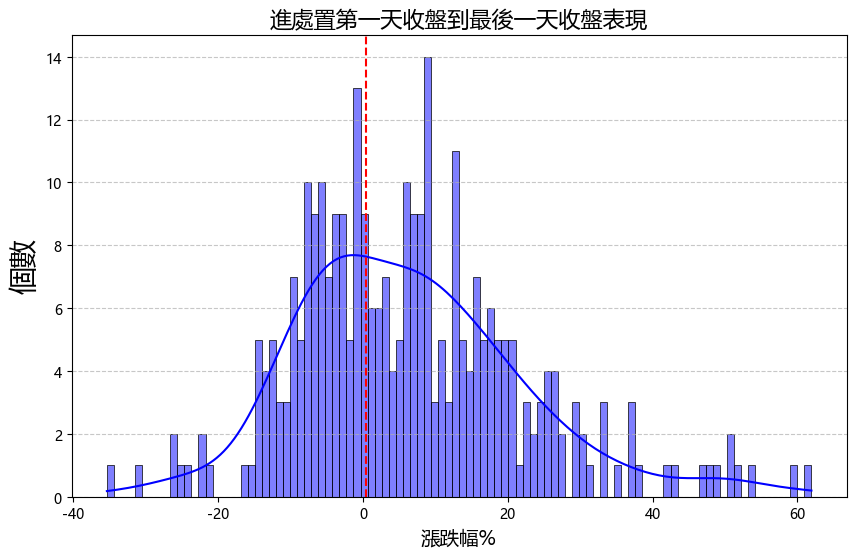

-7.912436974789915
15.913756906077348
勝率
0.6033333333333334


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] > -10) & (filtered_df3['前開收差'] > 0)]['起迄差']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('進處置第一天收盤到最後一天收盤表現', fontsize=16)  # 標題
plt.xlabel('漲跌幅%', fontsize=14)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].mean())
print(daylist[daylist > 0].mean())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))


In [54]:
filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] > -10)]

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,...,隔迄差,前開收差,起開收差,迄開收差,隔開收差,二起差,一收二開收差,迄收隔開差,隔3差,隔5差
1135,1280,109/06/08,1785,光洋科,2,2020-06-09,2020-06-22,2462.45,33.65,33.65,...,-3.26,0.00,0.00,2.86,-3.96,-2.30,0.00,0.73,1.35,14.59
468,524,109/06/08,1467,南緯,1,2020-06-09,2020-06-22,1823.05,20.30,21.05,...,-9.97,3.69,-5.68,0.90,-7.21,2.65,0.00,-2.98,34.94,40.48
1134,1278,109/06/09,4123,晟德,2,2020-06-10,2020-06-23,5809.60,79.00,76.60,...,-5.03,-3.04,4.03,2.24,-6.72,-9.14,1.12,1.81,1.00,-1.00
175,520,109/06/12,2417,圓剛,1,2020-06-15,2020-06-30,4006.60,20.50,22.85,...,-3.10,11.46,1.89,4.88,-4.10,-1.87,-1.03,1.03,30.72,55.46
1131,1267,109/06/17,4102,永日,2,2020-06-18,2020-07-03,1506.30,34.30,36.35,...,-1.69,5.98,-3.78,-4.28,-3.33,-8.07,0.98,1.69,19.10,4.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,21,113/10/30,8044,網家,2,2024-10-31,2024-11-13,2108.45,49.15,48.55,...,-7.00,-1.22,2.55,-1.27,-4.72,2.55,-2.48,-2.39,9.41,6.72
4,5,113/11/05,6442,光聖,1,2024-11-06,2024-11-19,9717.95,520.00,525.00,...,-2.30,0.96,-3.04,8.77,4.62,1.16,1.37,-6.62,-0.39,-4.12
501,17,113/11/05,8937,合騏,2,2024-11-06,2024-11-19,1410.75,93.10,98.60,...,-1.31,5.91,4.67,0.99,-2.89,6.10,3.40,1.63,37.86,34.95
0,4,113/11/12,6781,AES-KY,1,2024-11-13,2024-11-26,1151.25,738.00,728.00,...,-2.20,-1.36,2.98,1.87,-1.23,-1.83,0.26,-0.98,32.06,35.35


In [55]:
filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] < -10)]['起迄差'].mean()
# filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起迄差'] < -30)][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起開收差','起迄差']]
filter_new_df = filtered_df3[(filtered_df3['起日前20RS'] > 20) & (filtered_df3['起開收差'] > -10) & (filtered_df3['前開收差'] > 0)]
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

filter_new_df['ma5_diff'] = (filter_new_df['起日前日收盤價'] / filter_new_df['起日前5MA']) - 1
filter_new_ma5_df = filter_new_df[(filter_new_df['ma5_diff'] > 0.05) & (filter_new_df['ma5_diff'] < 0.15)]

C:\Users\USER\AppData\Local\Temp\ipykernel_6080\944173813.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_new_df['ma5_diff'] = (filter_new_df['起日前日收盤價'] / filter_new_df['起日前5MA']) - 1


C:\Users\USER\AppData\Local\Temp\ipykernel_6080\3525816405.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


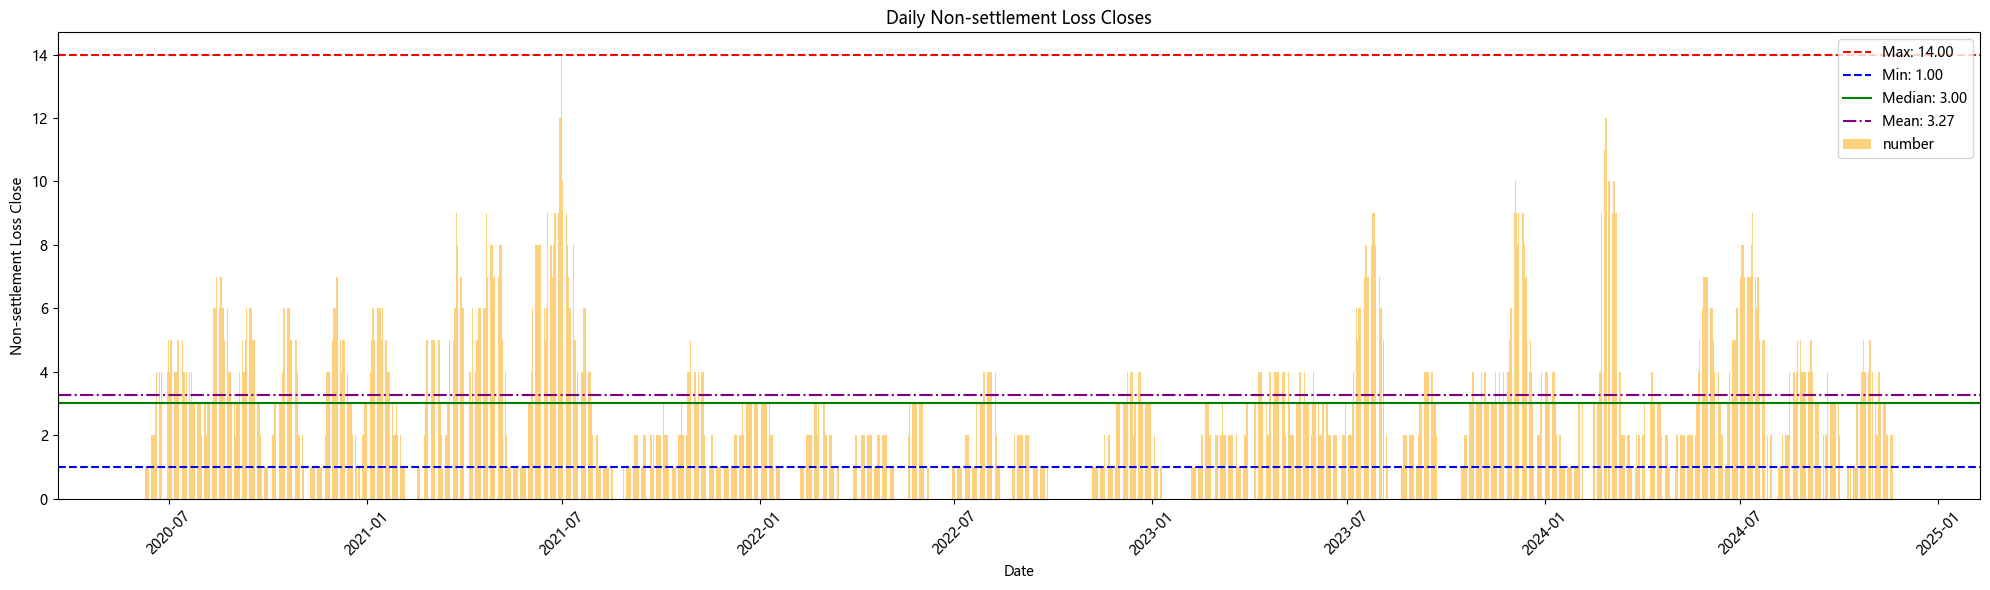

In [56]:

everyday_list = pd.DataFrame(columns=['hold_day','stock_id'])

for i in range(len(filter_new_df)):
    stock_info = filter_new_df.iloc[i]
    buy_date = stock_info['起日']
    sell_date = stock_info['迄日']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


everyday_list = everyday_list.groupby('hold_day').size()
everyday_list.columns = ['buy_date', 'size']
everyday_list = everyday_list.to_frame(name='size')

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(20, 6))

# Plot the first bar chart
# plt.bar(everyday_list.index, everyday_list['size'], width=1, label='VOL>20MA VOL', alpha=0.5)

# Plot the second bar chart on top with a different color and alpha for transparency
plt.bar(everyday_list.index, everyday_list['size'], width=1, label='number', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list["size"].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list["size"].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list["size"].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list["size"].mean():.2f}')

# Add titles and labels
plt.title('Daily Non-settlement Loss Closes')
plt.xlabel('Date')
plt.ylabel('Non-settlement Loss Close')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


這樣持倉實在太多了 沒辦法做這麼多筆

開始思考 MAE 分析

In [57]:
import pandas as pd
import numpy as np

# 初始化欄位
columns_to_init = [
    '持有最高價', '持有最低價','持有最高價日', '持有最低價日'
]
for col in columns_to_init:
    filtered_df2[col] = np.nan

# 定義更新函數
def update_stock_data(stock):
    stock_id = stock['證券代號']
    start_date = stock['起日']
    end_date = stock['迄日']
    buy_price = stock['起日收盤價']
    
    # 過濾單一股票資料
    stock_data = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
    
    # 起日前日
    search_date_dur = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

    if not search_date_dur.empty:

        min_price = search_date_dur['收盤價'].min()
        max_price = search_date_dur['收盤價'].max()
        min_date = search_date_dur[search_date_dur['收盤價'] == min_price]['Date'].iloc[0]
        max_date = search_date_dur[search_date_dur['收盤價'] == max_price]['Date'].iloc[0]

        stock['min_price'] = min_price
        stock['max_price'] = max_price
        stock['min_date'] = min_date
        stock['max_date'] = max_date

        loss_df = search_date_dur[search_date_dur['收盤價'] < buy_price*0.85]
        if not loss_df.empty:
            loss_price = loss_df['收盤價'].iloc[0]
            stock['loss_price'] = loss_price
            stock['loss_date'] = loss_df['Date'].iloc[0]
        else:
            stock['loss_price'] = 0
            stock['loss_date'] = '1911-01-01'

    # # 起日
    # search_date1 = stock_data[stock_data['Date'] >= start_date].head(1)
    # if not search_date1.empty:
    #     stock['起日開盤價'] = search_date1['開盤價'].iloc[0]
    #     stock['起日收盤價'] = search_date1['收盤價'].iloc[0]
    #     stock['起日20RS'] = search_date1['20RS_rank'].iloc[0]

    # # 第二天
    # search_date1 = stock_data[stock_data['Date'] > start_date].head(1)
    # if not search_date1.empty:
    #     stock['二日開盤價'] = search_date1['開盤價'].iloc[0]
    #     stock['二日收盤價'] = search_date1['收盤價'].iloc[0]
    #     stock['二日20RS'] = search_date1['20RS_rank'].iloc[0]
    
    
    return stock

# 使用 apply 進行批量更新
filter_new_ma5_df = filter_new_ma5_df.apply(update_stock_data, axis=1)

# 清理資料
filter_new_ma5_df = filter_new_ma5_df.dropna()
filter_new_ma5_df['loss_date'] = pd.to_datetime(filter_new_ma5_df['loss_date'], errors='coerce').dt.strftime('%Y-%m-%d')

filter_new_ma5_df['賣出價'] = filter_new_ma5_df.apply(
    lambda row: row['迄日收盤價'] if row['loss_price'] == 0 else row['loss_price'], axis=1
)

filter_new_ma5_df['賣出日'] = filter_new_ma5_df.apply(
    lambda row: row['迄日'] if row['loss_date'] == '1911-01-01' else row['loss_date'], axis=1
)

filter_new_ma5_df['起迄差_停損'] = 100 * (filter_new_ma5_df['賣出價'] - filter_new_ma5_df['起日收盤價']) / filter_new_ma5_df['起日收盤價']

filter_new_ma5_df['起迄差_停損'] = filter_new_ma5_df['起迄差_停損'].astype(float)
filter_new_ma5_df['起迄差_停損'] = round(filter_new_ma5_df['起迄差_停損'] , 2)

filter_new_ma5_df['ma5_diff'] = (filter_new_ma5_df['起日前日收盤價'] / filter_new_ma5_df['起日前5MA']) - 1

print(filter_new_ma5_df['起迄差'].mean())
print(filter_new_ma5_df['起迄差_停損'].mean())

# filter_new_ma5_df = filter_new_ma5_df[(filter_new_ma5_df['ma5_diff'] > 0.05) & (filter_new_ma5_df['ma5_diff'] < 0.15)]
# print(filter_new_ma5_df['起迄差'].mean())
# print(filter_new_ma5_df['起迄差_停損'].mean())

8.232459016393442
7.980655737704918


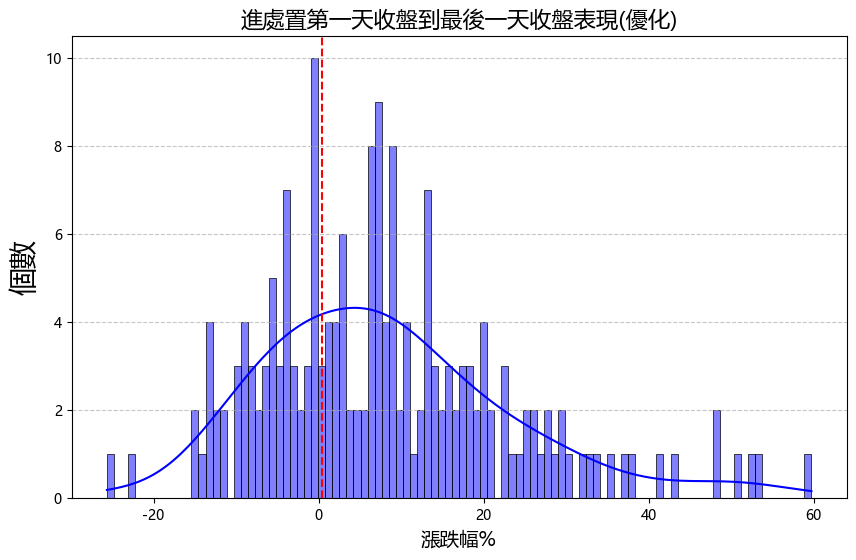

-6.717213114754099
15.969083333333334
勝率
0.6629834254143646


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = filter_new_ma5_df['起迄差']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('進處置第一天收盤到最後一天收盤表現(優化)', fontsize=16)  # 標題
plt.xlabel('漲跌幅%', fontsize=14)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].mean())
print(daylist[daylist > 0].mean())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))


In [59]:
print(filter_new_ma5_df[filter_new_ma5_df['二起差'] > 0][['起迄差','二起差']]['起迄差'].mean())
print(filter_new_ma5_df[filter_new_ma5_df['二起差'] > 0][['起迄差','二起差']]['二起差'].mean())

len(filter_new_ma5_df)

14.326500000000001
3.695125


183

In [60]:
filter_new_ma5_df[filter_new_ma5_df['起日前日收盤價'] < filter_new_ma5_df['起日前240MA']][['公布日期',	'證券代號',	'證券名稱','起日','迄日','起迄差', '起日前日收盤價','起日前240MA']]

,公布日期,證券代號,證券名稱,起日,迄日,起迄差,起日前日收盤價,起日前240MA
329,110/10/28,4968,立積,2021-10-29,2021-11-11,2.26,320.0,440.5646
598,111/04/20,6492,生華科,2022-04-21,2022-05-05,-22.65,110.0,124.3846


In [602]:
# filter_new_df[['迄日','賣出日','loss_price']].head(30)

如果把停損拉進來 會不會增加資金使用效率 (就可以趕快換到下一隻)

C:\Users\USER\AppData\Local\Temp\ipykernel_8564\725010976.py:22: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



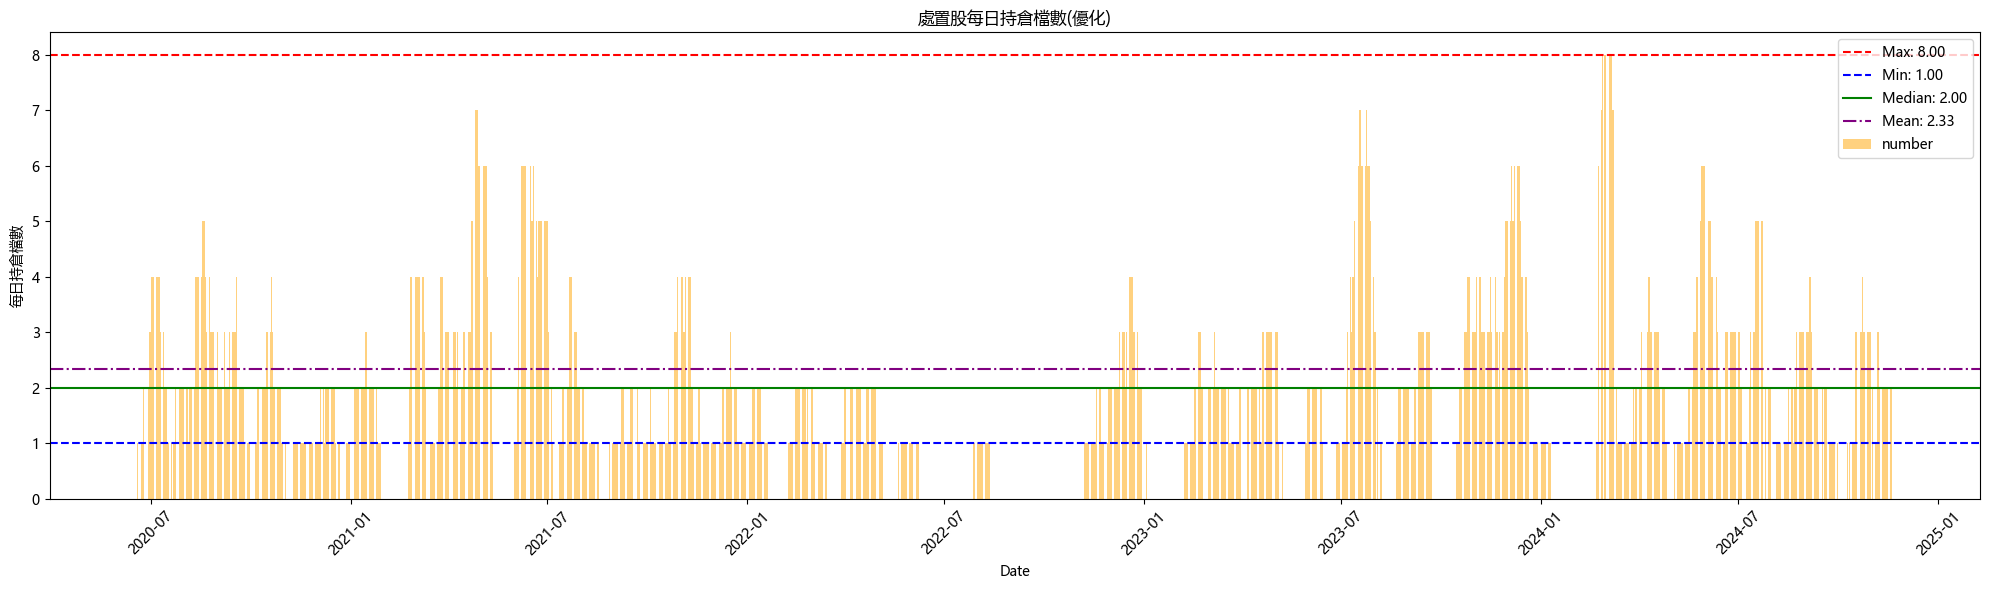

In [773]:
import matplotlib.pyplot as plt
everyday_list = pd.DataFrame(columns=['hold_day','stock_id'])

for i in range(len(filter_new_ma5_df)):
    stock_info = filter_new_ma5_df.iloc[i]
    buy_date = stock_info['起日']
    sell_date = stock_info['迄日']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


everyday_list = everyday_list.groupby('hold_day').size()
everyday_list.columns = ['buy_date', 'size']
everyday_list = everyday_list.to_frame(name='size')

# Set the figure size
plt.figure(figsize=(20, 6))

plt.bar(everyday_list.index, everyday_list['size'], width=1, label='number', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list["size"].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list["size"].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list["size"].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list["size"].mean():.2f}')

# Add titles and labels
plt.title('處置股每日持倉檔數(優化)')
plt.xlabel('Date')
plt.ylabel('每日持倉檔數')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [72]:
filter_new_ma5_df

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,...,ma5_diff,min_price,max_price,min_date,max_date,loss_price,loss_date,賣出價,賣出日,起迄差_停損
631,1260,109/06/18,5474,聰泰,2,2020-06-19,2020-07-06,1035.60,146.0,161.5,...,0.115331,177.50,212.5,2020-06-19,2020-07-06,0.0,1911-01-01,212.50,2020-07-06,19.72
453,513,109/06/23,3712,永崴投控,1,2020-06-24,2020-07-09,1771.15,28.6,28.8,...,0.131186,28.05,47.0,2020-06-24,2020-07-06,0.0,1911-01-01,44.80,2020-07-09,59.71
298,512,109/06/29,4133,亞諾法,1,2020-06-30,2020-07-13,15164.55,96.1,100.0,...,0.059098,96.00,153.0,2020-06-30,2020-07-09,0.0,1911-01-01,136.00,2020-07-13,41.67
185,510,109/07/01,3321,同泰,1,2020-07-02,2020-07-15,1079.25,17.1,17.3,...,0.144180,19.00,28.8,2020-07-02,2020-07-09,0.0,1911-01-01,20.45,2020-07-15,7.63
1122,1231,109/07/06,6223,旺矽,2,2020-07-07,2020-07-20,3850.55,116.5,117.5,...,0.098131,117.50,141.5,2020-07-07,2020-07-09,0.0,1911-01-01,125.00,2020-07-20,6.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,30,113/10/16,4991,環宇-KY,2,2024-10-17,2024-10-30,1786.05,62.0,63.2,...,0.088154,62.00,67.0,2024-10-28,2024-10-30,0.0,1911-01-01,67.00,2024-10-30,3.08
15,10,113/10/16,4956,光鋐,1,2024-10-17,2024-11-01,7928.85,37.0,41.5,...,0.136364,38.55,45.2,2024-10-30,2024-10-23,0.0,1911-01-01,41.20,2024-11-01,-1.08
12,8,113/10/22,4576,大銀微系統,1,2024-10-23,2024-11-07,5221.05,139.0,141.0,...,0.077982,133.50,151.0,2024-11-04,2024-10-28,0.0,1911-01-01,144.50,2024-11-07,0.00
4,5,113/11/05,6442,光聖,1,2024-11-06,2024-11-19,9717.95,520.0,525.0,...,0.056338,475.00,534.0,2024-11-18,2024-11-11,0.0,1911-01-01,521.00,2024-11-19,2.16


In [73]:
import numpy as np

# 假設 collected_data_day 已經定義
max_loss = filter_new_ma5_df['起迄差'].min()
result_list = []
f_list = []  # 保存對應的 f 值
f = 0.01

# 迴圈計算不同 f 對應的 HPR 和幾何平均
for f in np.arange(0.01, 2, 0.01):
    
    HPR_list = []
    for i in range(len(filter_new_ma5_df)):
        HPR =  1 + round(f, 2) * (filter_new_ma5_df['起迄差'].iloc[i] / max_loss)
        HPR_list.append(HPR)

    # 計算連續多筆相乘
    product_of_HPR = np.prod(HPR_list)

    # 開 n 次方 (n 是數列的長度)
    n = len(HPR_list)
    result = product_of_HPR ** (1/n)  
    result_list.append(result)  # 保存結果
    f_list.append(f)  # 保存對應的 f 值

# 找到 result_list 中的最大值及其對應的 f 值
max_result = max(result_list)
max_index = result_list.index(max_result)
optimal_f = f_list[max_index]

print(f"result_list 中的最大值是: {max_result}")
print(f"對應的最佳化 f 值是: {optimal_f}")


C:\Users\USER\AppData\Local\Temp\ipykernel_6080\715752773.py:22: RuntimeWarning: invalid value encountered in scalar power
  result = product_of_HPR ** (1/n)


result_list 中的最大值是: 0.9967741081338327
對應的最佳化 f 值是: 0.01


In [897]:
# filter_new_ma5_df.sort_values(by=['起日', 'ma5_diff'], ascending=[True, False]).head(30)

In [74]:
import pandas as pd
filter_new_ma5_df = filter_new_ma5_df.sort_values(by=['起日', 'ma5_diff'], ascending=[True, False])

# 初始化數據
data = filter_new_ma5_df[['編號','公布日期',	'證券代號',	'證券名稱',	'上市櫃',	'起日',	'迄日','起迄差']]

df = pd.DataFrame(data, columns=['編號', '公布日期', '證券代號', '證券名稱', '上市櫃', '起日', '迄日','起迄差'])

# 轉換日期格式
df['起日'] = pd.to_datetime(df['起日'])
df['迄日'] = pd.to_datetime(df['迄日'])

# 持倉計算
max_holding = 2
current_holding = []
holding_log = []

for index, row in df.iterrows():
    stock_id = row['證券代號']
    stock_name = row['證券名稱']
    start_date = row['起日']
    end_date = row['迄日']
    earn = row['起迄差']
    
    # 釋放已賣出的股票
    current_holding = [h for h in current_holding if h['迄日'] >= start_date]
    
    # 如果持倉未滿，則買入
    if len(current_holding) < max_holding:
        current_holding.append({'證券代號': stock_id, '證券名稱': stock_name, '起日': start_date, '迄日': end_date , '起迄差': earn})
        holding_log.append((stock_id, stock_name, start_date, end_date, earn))

# 將結果轉為 DataFrame
result = pd.DataFrame(holding_log, columns=['證券代號', '證券名稱', '起日', '迄日','起迄差'])
result['起迄差'] = result['起迄差']/max_holding

final_profit = result['起迄差'].cumsum().iloc[-1]
print(f"帳戶 {max_holding} 的最終收益: {final_profit}")

# 計算贏家與輸家的數量
win_count = len(result[result['起迄差'] > 0])
loss_count = len(result[result['起迄差'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(result)) * 100

# 計算平均獲利與平均損失
average_loss = result[result['起迄差'] <= 0]['起迄差'].mean() 
average_win = result[result['起迄差'] > 0]['起迄差'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


帳戶 2 的最終收益: 532.1649999999998
Win Count: 77
Loss Count: 35
勝率 (Win Rate): 68.75%
Average Loss (輸家平均損失): -3.47%
Average Win (贏家平均獲利): 8.49%


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\empyrical\stats.py:1424: RuntimeWarning: divide by zero encountered in scalar divide
  return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '210.153%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column

Start date,2020-06-01
End date,2024-11-28
Total months,52
,Backtest
Annual return,210.153%
Cumulative returns,13639.285%
Annual volatility,46.567%
Sharpe ratio,2.65
Calmar ratio,14.28
Stability,0.96
Max drawdown,-14.715%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.71,2020-10-20,2020-12-22,2021-01-25,70
1,11.48,2022-04-28,2022-05-05,2022-08-12,77
2,9.99,2024-09-05,2024-09-12,2024-11-19,54
3,7.73,2023-09-06,2023-10-27,2023-11-02,42
4,7.49,2022-12-20,2023-01-03,2023-02-22,47


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


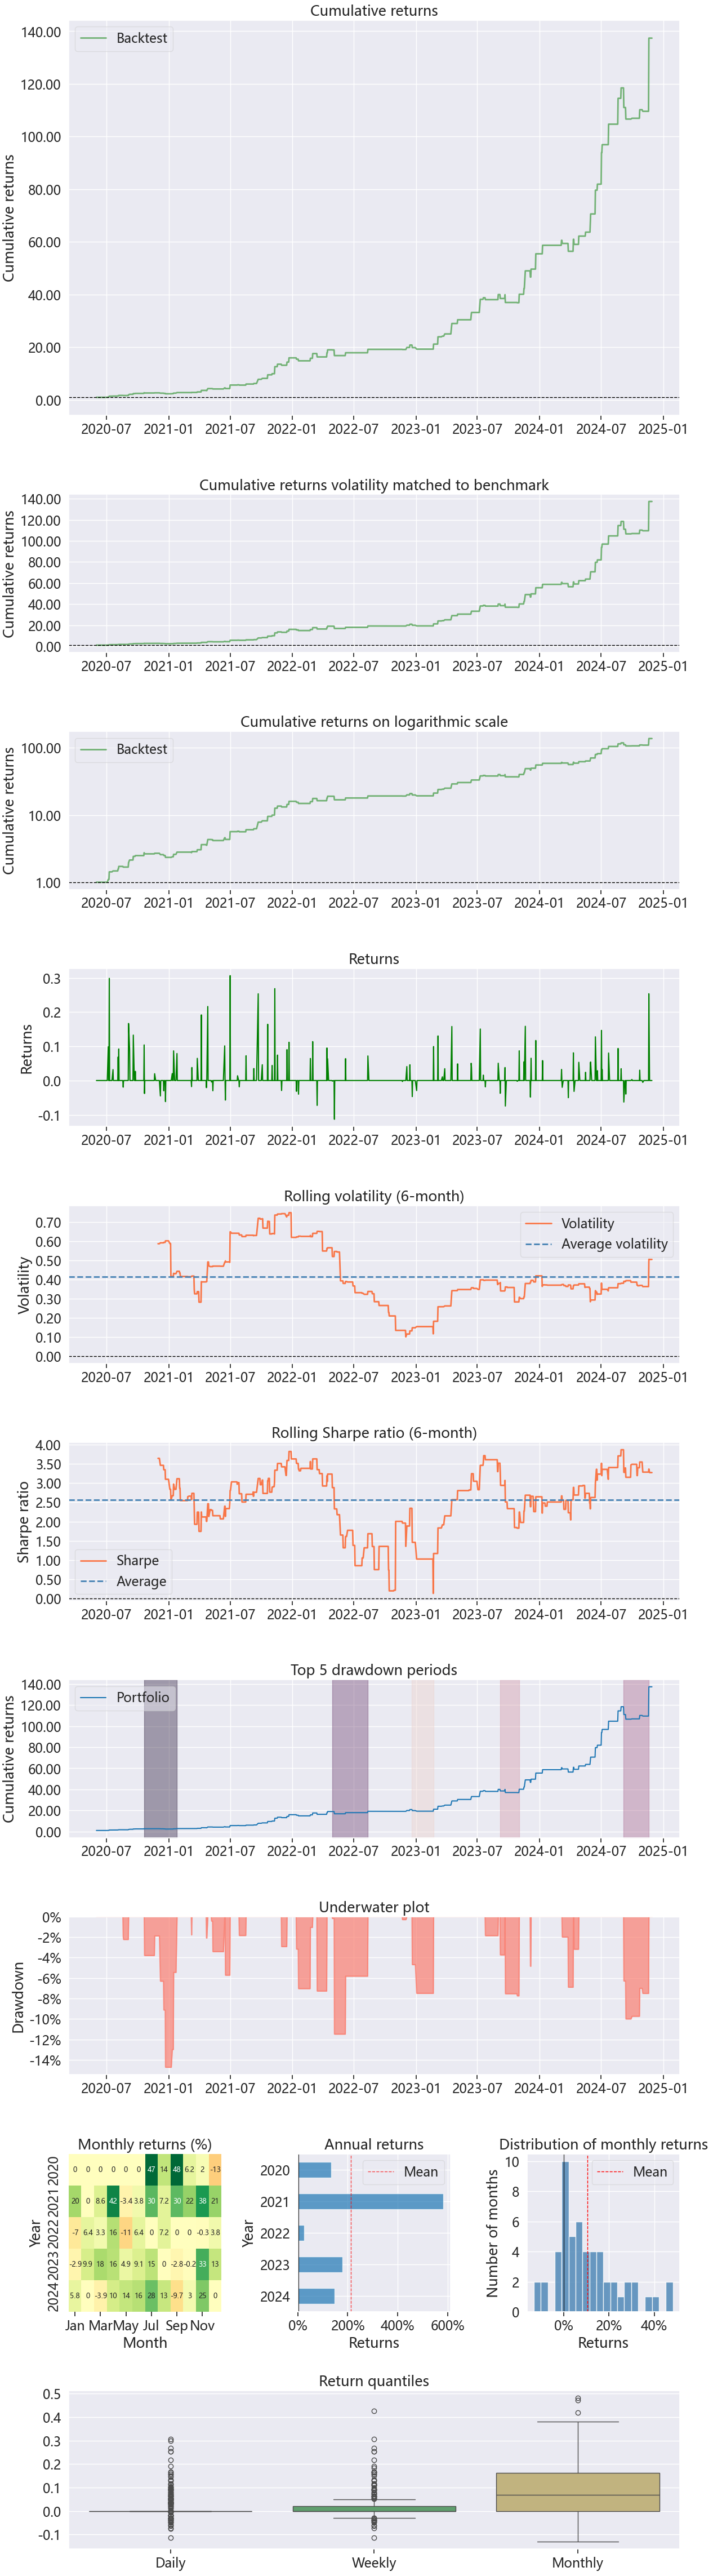

In [75]:
# 篩選日期範圍
Date_list = stock_2330.query("'2020-06-01' <= Date <= '2024-11-30'")['Date']

# 計算每個日期的收益，補全其他日期為 0
earn_price_list = (
    result[result['迄日'].isin(Date_list)]
    .groupby('迄日')['起迄差']
    .sum()
    .reindex(Date_list, fill_value=0)  # 補零
    .reset_index()
    .rename(columns={'迄日': 'Date', '起迄差': 'earn_price'})
)

# 將收益轉換為百分比
earn_price_list['earn_price'] /= 100

# 使用 pyfolio 分析收益
import pyfolio as pf
pf.create_returns_tear_sheet(earn_price_list.set_index('Date')['earn_price'])


C:\Users\USER\AppData\Local\Temp\ipykernel_6080\976700152.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


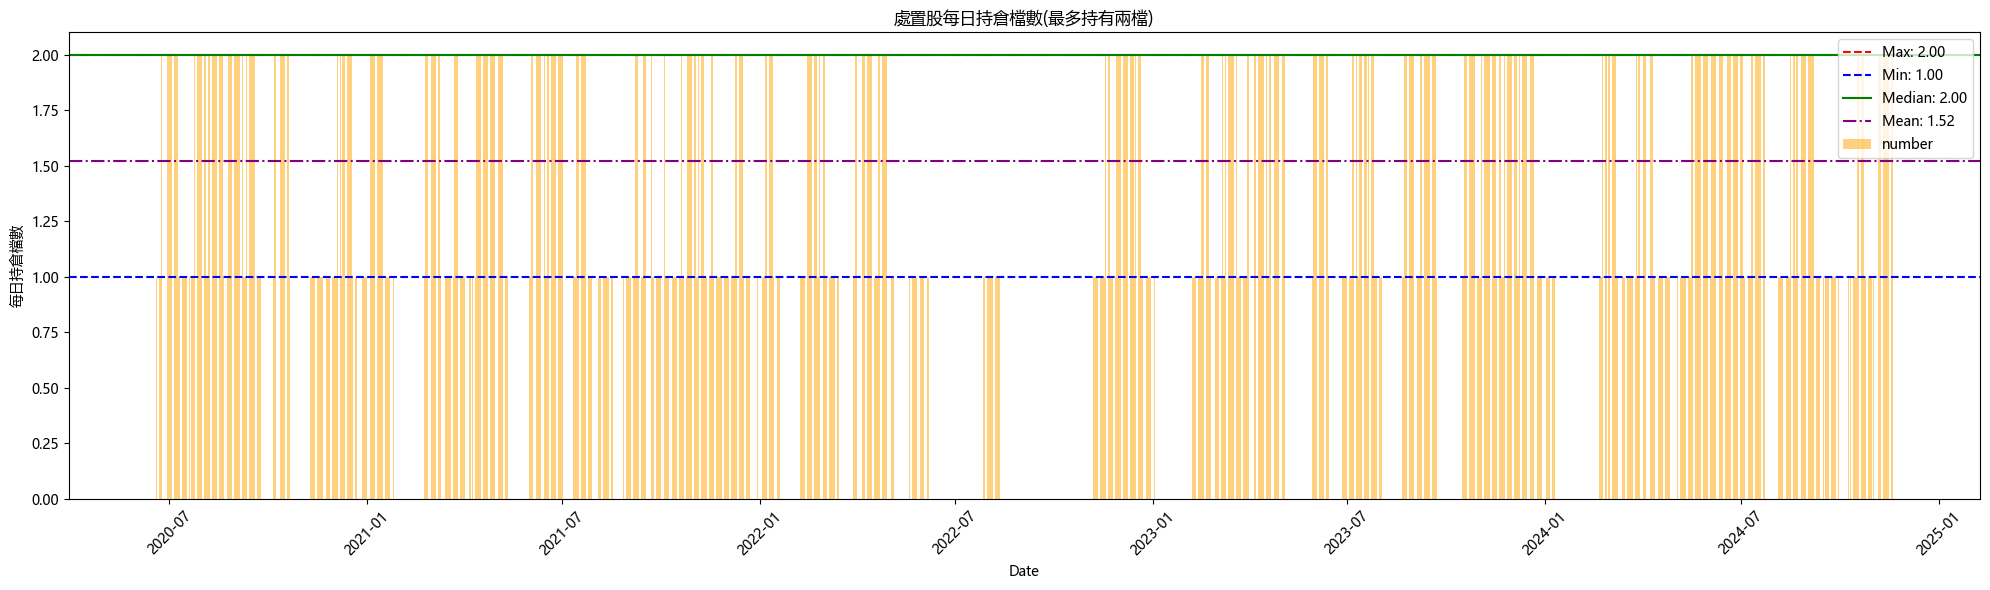

In [76]:
import matplotlib.pyplot as plt
everyday_list = pd.DataFrame(columns=['hold_day','stock_id'])

for i in range(len(result)):
    stock_info = result.iloc[i]
    buy_date = stock_info['起日']
    sell_date = stock_info['迄日']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


everyday_list = everyday_list.groupby('hold_day').size()
everyday_list.columns = ['buy_date', 'size']
everyday_list = everyday_list.to_frame(name='size')

# Set the figure size
plt.figure(figsize=(20, 6))

plt.bar(everyday_list.index, everyday_list['size'], width=1, label='number', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list["size"].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list["size"].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list["size"].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list["size"].mean():.2f}')

# Add titles and labels
plt.title('處置股每日持倉檔數(最多持有兩檔)')
plt.xlabel('Date')
plt.ylabel('每日持倉檔數')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [921]:
# result[result['迄日'] > '2020-12-01']

In [ ]:
final_profit = (result['起迄差'] / max_holding).cumsum().iloc[-1]
print(f"帳戶 {max_holding} 的最終收益: {final_profit}")

In [ ]:
# 試著將持倉調整為最多五檔
# 目前持倉
Date_list = stock_df_raw[(stock_df_raw['證券代號'] == '2330') & (stock_df_raw['Date'] >= '2020-06-17') & (stock_df_raw['Date'] <= '2020-10-23') ]['Date']

my_account_list = list(range(2, 3, 1)) 


for my_account in my_account_list:
    remaning_accout = my_account

    # 只能賣不能買
    only_sell = False

    my_stock_hold = pd.DataFrame(columns=['count','buy_date'])

    exit_stock_list  = pd.DataFrame(columns=filter_new_ma5_df.columns)


    for select_day in Date_list:

        today_buy = filter_new_ma5_df[(filter_new_ma5_df['起日'] == select_day)  ].sort_values(by='ma5_diff', ascending=True )  # 同一天沒關係 剛好交割起來
        # 有買才能有賣
        today_sell = exit_stock_list[(exit_stock_list['迄日'] == select_day) ].sort_values(by='ma5_diff')   # 同一天沒關係 剛好交割起來

        if( (len(today_buy) == 0) & (len(today_sell) == 0) ):
            continue

        # 要先賣股票
        if (only_sell) :
            
            if (len(today_sell) > 0) :
                remaning_accout = len(today_sell)
                only_sell = False
            else :
                continue
        else :

            # 如果今天要買的大於賣出的 就得動用資金
            today_need = len(today_buy) - len(today_sell)

            # 買進比賣出多 需要動用股票
            if (today_need > 0) :

                # 目前帳戶還能買幾檔
                account_need = remaning_accout - today_need

                if (account_need < 0) :
                    
                    today_stock = today_buy.head(remaning_accout)
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 
                    remaning_accout = 0

                else:
                    # 全收
                    today_stock = today_buy
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 
                    remaning_accout = account_need 

            else: 
                # 釋出資金
                remaning_accout = remaning_accout - today_need

                #如果有買進一樣全收
                if(len(today_buy) > 0) :

                    today_stock = today_buy
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 

            # 檢查目前狀況
            if (remaning_accout == 0):
                only_sell = True
            else :
                only_sell = False
                
    exit_stock_list = exit_stock_list.sort_values(by='迄日')
    # print((exit_stock_list['earn_mix']/my_account).cumsum().iloc[-1])

C:\Users\USER\AppData\Local\Temp\ipykernel_8564\4186029795.py:56: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [ ]:
filter_new_df[filter_new_df['起迄差'] < -15][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起迄差','起日前日收盤價', '起日前5MA']]

ma5_diff = (filter_new_df[filter_new_df['起迄差'] < -15]['起日前日收盤價'] / filter_new_df[filter_new_df['起迄差'] < -15]['起日前10MA']) - 1
filter_new_df['ma5_diff'] = (filter_new_df['起日前日收盤價'] / filter_new_df['起日前5MA']) - 1



In [731]:
filter_new_df[filter_new_df['起日前日收盤價'] > filter_new_df['起日前5MA']]['起迄差'].mean()

filter_new_df[(filter_new_df['起日前日收盤價'] > filter_new_df['起日前5MA']) & (filter_new_df['起日前5MA'] != 0)]['起迄差'].mean()

filter_new_df[(filter_new_df['ma5_diff'] > 0.05) & (filter_new_df['ma5_diff'] < 0.15)]['起迄差']

631     19.72
453     59.71
298     41.67
185      7.63
1122     6.38
        ...  
510      3.08
15      -1.08
12       0.00
501     48.54
4        2.16
Name: 起迄差, Length: 183, dtype: float64

In [726]:
import numpy as np

for i in np.arange(0.05, 0.20, 0.01):  # 設定範圍 0.10 到 0.20，每次增加 0.01
    mean_value = filter_new_df[filter_new_df['ma5_diff'] > i]['隔迄差'].mean()
    print(f"當 ma5_diff > {i:.2f} 時，'起迄差' 的平均值為: {mean_value}")


當 ma5_diff > 0.05 時，'起迄差' 的平均值為: -0.9423828124999999
當 ma5_diff > 0.06 時，'起迄差' 的平均值為: -0.9055042016806721
當 ma5_diff > 0.07 時，'起迄差' 的平均值為: -0.8249099099099099
當 ma5_diff > 0.08 時，'起迄差' 的平均值為: -0.3297927461139897
當 ma5_diff > 0.09 時，'起迄差' 的平均值為: -0.0050588235294117614
當 ma5_diff > 0.10 時，'起迄差' 的平均值為: 0.1337748344370862
當 ma5_diff > 0.11 時，'起迄差' 的平均值為: 0.2651879699248121
當 ma5_diff > 0.12 時，'起迄差' 的平均值為: 0.5361344537815126
當 ma5_diff > 0.13 時，'起迄差' 的平均值為: 0.9695145631067961
當 ma5_diff > 0.14 時，'起迄差' 的平均值為: 1.4363043478260875
當 ma5_diff > 0.15 時，'起迄差' 的平均值為: 1.8483561643835618
當 ma5_diff > 0.16 時，'起迄差' 的平均值為: 2.562580645161291
當 ma5_diff > 0.17 時，'起迄差' 的平均值為: 2.6301923076923086
當 ma5_diff > 0.18 時，'起迄差' 的平均值為: 3.478461538461539
當 ma5_diff > 0.19 時，'起迄差' 的平均值為: 4.513599999999999
當 ma5_diff > 0.20 時，'起迄差' 的平均值為: nan


In [ ]:
import numpy as np

for i in np.arange(0.05, 0.20, 0.01):  # 設定範圍 0.10 到 0.20，每次增加 0.01
    mean_value = filter_new_df[filter_new_df['ma5_diff'] > i]['起迄差'].mean()
    print(f"當 ma5_diff > {i:.2f} 時，'起迄差' 的平均值為: {mean_value}")


In [619]:
punishment_df = filter_new_df[filter_new_df['起迄差'] < -15]
file_path = 'c:/Users/USER/OneDrive/桌面/佛爾德/stock/punishment.xlsx'
punishment_df.to_excel(file_path, index=False)

In [620]:
punishment_df

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,...,前開收差,min_price,max_price,min_date,max_date,loss_price,loss_date,賣出價,賣出日,起迄差_停損
647,1220,109/07/08,6535,順藥,2,2020-07-09,2020-07-22,1232.20,58.4,58.50,...,0.17,37.75,64.70,2020-07-20,2020-07-10,52.5,2020-07-14,52.5,2020-07-14,-18.35
632,1142,109/09/01,5474,聰泰,2,2020-09-02,2020-09-15,2357.00,333.0,337.50,...,1.35,292.50,371.00,2020-09-11,2020-09-02,292.5,2020-09-11,292.5,2020-09-11,-21.16
350,355,110/06/30,2607,榮運,1,2021-07-01,2021-07-14,23734.10,45.0,49.60,...,10.22,36.30,49.00,2021-07-13,2021-07-01,41.0,2021-07-07,41.0,2021-07-07,-16.33
352,355,110/06/30,2611,志信,1,2021-07-01,2021-07-14,6509.10,39.5,42.40,...,7.34,30.00,43.50,2021-07-14,2021-07-01,36.1,2021-07-07,36.1,2021-07-07,-17.01
598,631,111/04/20,6492,生華科,2,2022-04-21,2022-05-05,1059.80,108.0,110.00,...,1.85,87.20,113.00,2022-05-04,2022-04-21,88.1,2022-04-26,88.1,2022-04-26,-22.04
897,564,111/09/12,3205,佰研,2,2022-09-13,2022-09-26,3360.05,64.1,64.30,...,0.31,47.65,62.50,2022-09-26,2022-09-13,52.9,2022-09-23,52.9,2022-09-23,-15.36
887,541,111/12/26,4747,強生,2,2022-12-27,2023-01-10,1255.65,60.6,60.70,...,0.17,44.05,59.00,2023-01-10,2022-12-27,49.0,2023-01-03,49.0,2023-01-03,-16.95
808,408,112/07/21,6150,撼訊,2,2023-07-24,2023-08-04,2725.30,104.5,113.50,...,8.61,79.80,109.50,2023-08-02,2023-07-24,91.4,2023-07-31,91.4,2023-07-31,-16.53
801,402,112/07/25,6811,宏碁資訊,2,2023-07-26,2023-08-08,1472.10,370.0,397.00,...,7.30,304.50,393.00,2023-08-08,2023-07-26,327.0,2023-08-02,327.0,2023-08-02,-16.79
202,119,112/12/01,1325,恆大,1,2023-12-04,2023-12-15,1212.20,36.8,39.05,...,6.11,32.70,42.95,2023-12-12,2023-12-04,34.5,2023-12-11,34.5,2023-12-11,-19.67


In [621]:
filter_new_df[filter_new_df['起迄差'] > 15]

,編號,公布日期,證券代號,證券名稱,上市櫃,起日,迄日,20MAV,起日前日開盤價,起日前日收盤價,...,前開收差,min_price,max_price,min_date,max_date,loss_price,loss_date,賣出價,賣出日,起迄差_停損
468,524,109/06/08,1467,南緯,1,2020-06-09,2020-06-22,1823.05,20.3,21.05,...,3.69,20.75,35.85,2020-06-09,2020-06-18,0.0,1911-01-01,33.60,2020-06-22,61.93
175,520,109/06/12,2417,圓剛,1,2020-06-15,2020-06-30,4006.60,20.5,22.85,...,11.46,23.20,29.00,2020-06-23,2020-06-30,0.0,1911-01-01,29.00,2020-06-30,19.59
631,1260,109/06/18,5474,聰泰,2,2020-06-19,2020-07-06,1035.60,146.0,161.50,...,10.62,177.50,212.50,2020-06-19,2020-07-06,0.0,1911-01-01,212.50,2020-07-06,19.72
453,513,109/06/23,3712,永崴投控,1,2020-06-24,2020-07-09,1771.15,28.6,28.80,...,0.70,28.05,47.00,2020-06-24,2020-07-06,0.0,1911-01-01,44.80,2020-07-09,59.71
298,512,109/06/29,4133,亞諾法,1,2020-06-30,2020-07-13,15164.55,96.1,100.00,...,4.06,96.00,153.00,2020-06-30,2020-07-09,0.0,1911-01-01,136.00,2020-07-13,41.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,36,113/08/02,2524,京城,1,2024-08-05,2024-08-20,6227.65,112.5,115.50,...,2.67,93.60,136.00,2024-08-06,2024-08-19,0.0,1911-01-01,123.50,2024-08-20,18.75
559,84,113/08/15,3230,錦明,2,2024-08-16,2024-08-29,1625.50,29.4,32.70,...,11.22,33.25,48.85,2024-08-16,2024-08-28,0.0,1911-01-01,48.85,2024-08-29,46.92
536,64,113/09/03,3081,聯亞,2,2024-09-04,2024-09-20,4753.85,187.0,194.50,...,4.01,187.50,235.50,2024-09-05,2024-09-19,0.0,1911-01-01,235.50,2024-09-20,22.98
10,7,113/10/28,3447,展達,1,2024-10-29,2024-11-13,3815.80,80.0,81.40,...,1.75,79.20,100.00,2024-10-30,2024-11-13,0.0,1911-01-01,100.00,2024-11-13,24.07


In [591]:
filter_new_df[filter_new_df['起迄差_停損'] < -15]['起迄差_停損'].min()

-22.33

5.18652097902098
3.054737762237762


4.588898601398602

In [572]:
filter_new_df['min差'] = 100 * (filter_new_df['min_price'] - filter_new_df['起日收盤價']) / filter_new_df['起日收盤價']
filter_new_df['max差'] = 100 * (filter_new_df['max_price'] - filter_new_df['起日收盤價']) / filter_new_df['起日收盤價']

filter_new_df['min差'] = filter_new_df['min差'].astype(float)
filter_new_df['min差'] = round(filter_new_df['min差'] , 2)

filter_new_df['max差'] = filter_new_df['max差'].astype(float)
filter_new_df['max差'] = round(filter_new_df['max差'] , 2)

In [ ]:
filter_new_df[(filter_new_df['min差'] < -10) & (filter_new_df['起迄差'] > 0)][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起迄差','min差','max差']]
filter_new_df[(filter_new_df['起迄差'] < -15)][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起迄差','min差','max差']]

,公布日期,證券代號,證券名稱,起日,迄日,起迄差,min差,max差
465,109/06/19,1474,弘裕,2020-06-22,2020-07-07,-19.95,-19.95,0.00
334,109/07/08,1734,杏輝,2020-07-09,2020-07-22,-35.87,-41.65,9.92
647,109/07/08,6535,順藥,2020-07-09,2020-07-22,-35.38,-41.29,0.62
632,109/09/01,5474,聰泰,2020-09-02,2020-09-15,-15.36,-21.16,0.00
122,109/09/18,9136,巨騰-DR,2020-09-21,2020-10-06,-23.53,-25.16,13.40
393,110/04/29,6116,彩晶,2021-05-03,2021-05-14,-31.62,-32.38,0.00
391,110/05/05,1441,大東,2021-05-06,2021-05-19,-22.46,-32.46,3.99
389,110/05/18,1732,毛寶,2021-05-19,2021-06-01,-25.61,-26.42,0.00
871,110/05/21,6472,保瑞,2021-05-24,2021-06-04,-24.59,-26.37,0.00
356,110/06/29,2612,中航,2021-06-30,2021-07-13,-26.73,-26.73,1.38


In [575]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn2 = filter_new_df[filter_new_df['起迄差'] > 0]
negative_earn2 = filter_new_df[filter_new_df['起迄差'] < 0]


fig = px.histogram(positive_earn2, 
                   x='min差',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["blue"])  # Customize labels


# Create bubble chart for positive earn2 (blue)
fig2 = px.histogram(negative_earn2, 
                   x='min差',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100,
                   color_discrete_sequence=["red"])  # Customize labels

# # Add bubble chart for negative earn2 (red)
# fig2 = px.scatter(negative_earn2, 
#                   x= negative_earn2['earn_mix'], 
#                   y= abs(negative_earn2['BMFE']), 
#                   size= abs(negative_earn2['earn_mix']),
#                   title="BMFE/Return",  
#                   size_max=20,
#                   color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show() 

In [ ]:
filter_new_df[(filter_new_df['min差'] < -10) & (filter_new_df['起迄差'] > 0)][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起迄差','min差','max差']]
filter_new_df[(filter_new_df['起迄差'] < -15)][['公布日期',	'證券代號',	'證券名稱','起日',	'迄日','起迄差','min差','max差']]

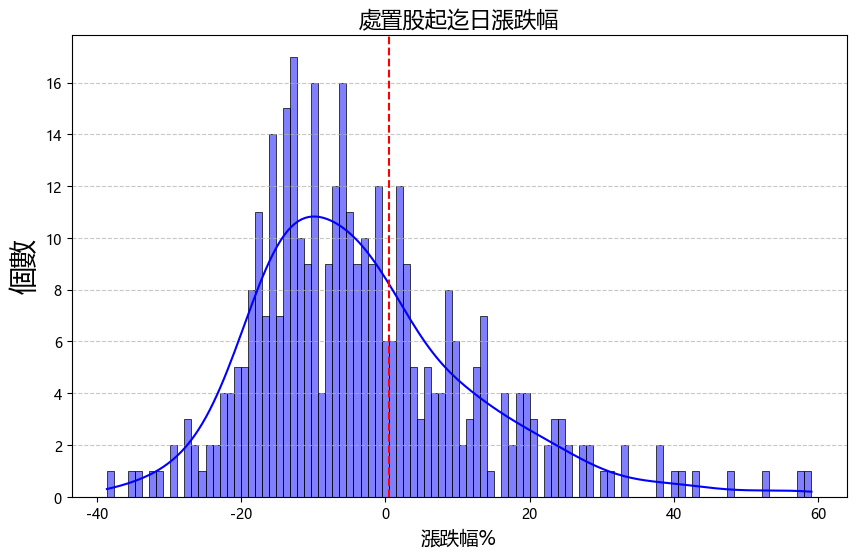

-2874.3199999999997
1745.02
勝率
0.34688346883468835


In [252]:


import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = filtered_df3['diff4']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('處置股起迄日漲跌幅', fontsize=16)  # 標題
plt.xlabel('漲跌幅%', fontsize=14)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].sum())
print(daylist[daylist > 0].sum())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))


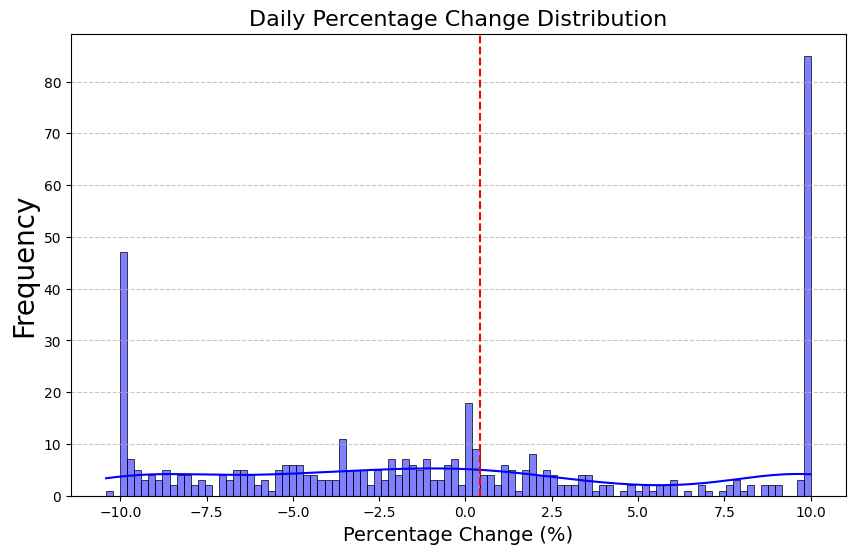

-1406.48
1245.57
勝率
0.44370860927152317


In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# 計算每日百分比變動
daylist = filtered_df3['diff2']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('Daily Percentage Change Distribution', fontsize=16)  # 標題
plt.xlabel('Percentage Change (%)', fontsize=14)  # x 軸標籤
plt.ylabel('Frequency', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].sum())
print(daylist[daylist > 0].sum())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))

In [92]:
stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > end_date)].head(1)

,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
99517,2020-04-06,4739,康普,374860,311,15351310,42.8,42.8,39.7,41.0,...,0.0,0.0,0.973093,37.817552,0.0,58.314088,0.0,0.0,0.0,58.314088


In [ ]:
filtered_df2['起日收盤價'] = '' 
filtered_df2['迄日收盤價'] = ''
filtered_df2['隔日收盤價'] = ''

for i in range(len(filtered_df2)): # 這次跑的策略股票
    # 取出單一各股
    stock = filtered_df2.iloc[i]

    stock_id = stock['證券代號']
    start_date = stock['起日']
    end_date = stock['迄日']


    search_date = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] == start_date)]

    filtered_df2['起日收盤價'] = search_date['收盤價']





In [78]:
# 執行 inner join
merged_df = pd.merge(
    filtered_df2, 
    stock_df_raw, 
    left_on=[ '證券代號'], 
    right_on=[ '證券代號'],
    how='inner'
)

merged_df

,編號,公布日期,證券代號,證券名稱_x,累計,處置條件,起日,迄日,Date,證券名稱_y,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank


In [ ]:
data = filtered_df[filtered_df['證券代號'] == 3593]


# 建立 DataFrame
df = pd.DataFrame(data)

# 排序資料
df['起日'] = pd.to_datetime(df['起日'])
df['迄日'] = pd.to_datetime(df['迄日'])
df = df.sort_values(by=['證券代號', '起日']).reset_index(drop=True)

# 合併日期範圍的函數
def merge_date_ranges(group):
    merged = []
    for _, row in group.iterrows():
        if not merged or merged[-1]['迄日'] < row['起日'] - pd.Timedelta(days=1):
            # 沒有重疊，新增新的範圍
            merged.append(row)
        else:
            # 合併重疊的範圍
            merged[-1]['迄日'] = max(merged[-1]['迄日'], row['迄日'])
    return pd.DataFrame(merged)

# 按證券代號分組並合併日期範圍
result = df.groupby(['證券代號', '證券名稱'], group_keys=False).apply(merge_date_ranges)

# 顯示結果
print(result)

   編號       公布日期   累計  處置條件         起日         迄日  證券代號 證券名稱
0  41  113/07/12  1.0  連續三次 2024-07-15 2024-07-26  3593   力銘
1   2  113/11/22  1.0  連續三次 2024-11-25 2024-12-11   NaN  NaN


C:\Users\USER\AppData\Local\Temp\ipykernel_8564\2544805810.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: merge_date_ranges(group.drop(columns=['證券代號', '證券名稱'])))


In [36]:
stock_df_raw[stock_df_raw['Date'] == filtered_df['起日'].iloc[20]]


,Date,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
1606967,2024-09-18,0050,元大台灣50,9649985,14610,1713884250,178.50,179.10,176.55,177.85,...,182.4367,97.4859,1.005132,60.560345,1.005495,54.471983,153.9237,115.5442,1.048816,78.071121
1606968,2024-09-18,0051,元大中型100,108942,305,8654184,79.75,79.75,79.00,79.25,...,81.4017,97.3567,0.996740,49.515086,1.004163,53.717672,76.4508,103.6614,0.940954,59.105603
1606969,2024-09-18,0052,富邦科技,231915,1215,40214184,174.40,174.45,172.15,173.20,...,179.1242,96.6927,1.001060,55.441810,0.997314,49.892241,150.0377,115.4376,1.047849,77.855603
1606970,2024-09-18,0053,元大電子,9429,118,902325,95.80,96.10,94.85,94.85,...,98.6200,96.1772,0.995956,48.006466,0.991997,46.336207,82.9956,114.2831,1.037369,76.508621
1606971,2024-09-18,0055,元大MSCI金融,127463,355,3655451,28.60,28.81,28.60,28.61,...,28.5022,100.3783,1.005107,60.452586,1.035328,69.935345,25.5212,112.1030,1.017580,73.383621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608818,2024-09-18,9951,皇田,82954,134,5358292,64.50,65.00,64.20,64.20,...,68.5967,93.5906,0.988956,39.170259,0.965318,31.411638,72.1658,88.9618,0.807523,20.851293
1608819,2024-09-18,9955,佳龍,1281899,1112,46980526,36.85,37.05,36.35,36.45,...,35.7050,102.0865,1.009547,65.732759,1.052947,76.831897,28.8327,126.4189,1.147528,86.260776
1608820,2024-09-18,9958,世紀鋼,5711819,4442,1217073090,207.50,217.00,207.00,213.50,...,238.7250,89.4334,0.984007,33.405172,0.922440,12.877155,219.9021,97.0887,0.881292,41.002155
1608821,2024-09-18,9960,邁達康,77131,69,1985577,25.80,25.85,25.65,25.65,...,27.0375,94.8682,0.987195,37.230603,0.978496,38.685345,26.7081,96.0382,0.871757,37.984914


In [91]:
# temp_stock = stock_df_raw[stock_df_raw['證券代號'] == '3706'].copy()

# temp_stock.loc[:, '5MAV'] = temp_stock['成交筆數'].rolling(5).mean()
# temp_stock.loc[:, '8MAV'] = temp_stock['成交筆數'].rolling(8).mean()
# temp_stock.loc[:, '10MAV'] = temp_stock['成交筆數'].rolling(10).mean()
# temp_stock.loc[:, '20MAV']= temp_stock['成交筆數'].rolling(20).mean()
# temp_stock.loc[:, '60MAV']= temp_stock['成交筆數'].rolling(60).mean()
# temp_stock.loc[:, '240MAV']= temp_stock['成交筆數'].rolling(240).mean()

# temp_col_stock = temp_stock.tail(50)[['Date', '證券代號','證券名稱','成交筆數', '5MAV', '10MAV', '20MAV', '60MAV']]

# temp_col_stock[temp_col_stock['5MAV'] > 2 * temp_col_stock['60MAV']]


In [173]:
# Prepare DataFrame for results
vol_df = pd.DataFrame(columns=['Date', '證券代號', '證券名稱', '成交筆數', '5MAV', '10MAV', '20MAV', '60MAV'])

# Filter stock data after '2024-01-01'
test = stock_df_raw[(stock_df_raw['Date'] >= '2022-01-01') & (stock_df_raw['Date'] <= '2022-12-31')].copy()

# Group by '證券代號' and process each group
for stock_id, single in test.groupby('證券代號'):
    single['5MAV'] = single['成交筆數'].rolling(5).mean()
    single['10MAV'] = single['成交筆數'].rolling(10).mean()
    single['20MAV'] = single['成交筆數'].rolling(20).mean()
    single['60MAV'] = single['成交筆數'].rolling(60).mean()
    
    # Identify rows where 5MAV is more than double 60MAV
    vol_up_list = single[single['5MAV'] > 2 * single['60MAV']]
    
    if not vol_up_list.empty:
        vol_up_1 = vol_up_list.iloc[[0]]  # First row meeting condition
        # price_check = abs((vol_up_1['收盤價'].values[0] - vol_up_1['60MA'].values[0]) / vol_up_1['收盤價'].values[0]) < 0.15

        rs_check = vol_up_1['20RS_rank'].values[0] > 90

        ma_check = (vol_up_1['收盤價'].values[0] > vol_up_1['240MA'].values[0]) & (vol_up_1['收盤價'].values[0] > vol_up_1['60MA'].values[0]) & (vol_up_1['收盤價'].values[0] > vol_up_1['開盤價'].values[0])
        
        if rs_check & ma_check:
            # vol_up_1 = vol_up_1[['Date', '證券代號', '證券名稱', '成交筆數', '5MAV', '10MAV', '20MAV', '60MAV']]
            vol_df = pd.concat([vol_df, vol_up_1], ignore_index=True)

vol_df = vol_df[vol_df['成交筆數'] > 1000].sort_values(by='Date')
vol_df

,Date,證券代號,證券名稱,成交筆數,5MAV,10MAV,20MAV,60MAV,成交股數,成交金額,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
44,2022-04-08,2031,新光鋼,3244,6916.6,6205.1,4745.90,2951.100000,5432735.0,3.736685e+08,...,60.2917,114.7754,1.061319,90.435767,1.184820,96.264856,63.6138,108.7815,1.095222,80.588568
32,2022-04-08,1722,台肥,22670,11307.6,11615.9,9886.55,4713.766667,38582078.0,3.062731e+09,...,70.8150,112.9704,1.084189,94.736842,1.166187,94.680249,64.3267,124.3652,1.252120,92.812677
144,2022-04-08,4133,亞諾法,36584,14570.8,7987.9,4190.40,3214.200000,64602166.0,3.952362e+09,...,43.9575,145.3677,1.516817,100.000000,1.500622,99.547255,48.5792,131.5379,1.324335,96.095076
145,2022-04-08,4148,全宇生技-KY,2252,1623.6,1350.2,1675.85,722.666667,3522346.0,2.591184e+08,...,50.7375,148.4109,1.164603,98.754952,1.532037,99.603848,40.0746,187.8996,1.891790,99.603848
29,2022-04-08,1708,東鹼,29638,39509.0,52603.2,38776.90,18367.716667,76475774.0,4.629029e+09,...,41.5383,148.5375,1.204056,99.094510,1.533344,99.660441,34.4660,179.0168,1.802357,99.434069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,2022-09-21,5607,遠雄港,1408,768.8,529.2,479.05,372.750000,2294153.0,1.334781e+08,...,51.0467,115.5805,1.123560,95.664414,1.186518,92.736486,55.2613,106.7656,1.228925,78.490991
219,2022-11-02,6269,台郡,6098,2902.0,1835.3,1421.65,1373.716667,6309691.0,6.238063e+08,...,92.4400,106.4474,1.083628,92.628025,1.148379,92.459201,95.0129,103.5649,1.278063,85.931345
20,2022-11-14,1590,亞德客-KY,2536,1462.2,989.6,848.20,689.183333,962147.0,8.706692e+08,...,770.0667,118.8209,1.113468,96.067416,1.164745,96.460674,874.0417,104.6861,1.183605,81.910112
280,2022-11-23,9902,台火,1815,445.8,251.3,146.80,78.300000,5831368.0,7.257730e+07,...,10.4958,119.5713,1.118956,96.235955,1.131170,95.393258,11.5996,108.1935,1.180484,84.550562


In [144]:
vol_df[vol_df['證券名稱'] == '神達']

,Date,證券代號,證券名稱,成交筆數,5MAV,10MAV,20MAV,60MAV,成交股數,成交金額,...,60MA,60RS,20RS_sd,20RS_rank,60RS_sd,60RS_rank,240MA,240RS,240RS_sd,240RS_rank
204,2024-11-08,3706,神達,26374,10770.2,6434.9,4976.4,3923.333333,93055212.0,4.992858e+09,...,45.4175,118.8969,1.127886,98.22676,1.132927,95.969909,44.8969,120.2756,1.050229,85.652875


In [ ]:
vol_df[vol_df['證券名稱'] == '神達']
# Prepare DataFrame for results
vol_df = pd.DataFrame(columns=['Date', '證券代號', '證券名稱', '成交筆數', '5MAV', '10MAV', '20MAV', '60MAV'])

# Filter stock data after '2024-01-01'
test = stock_df_raw[stock_df_raw['Date'] > '2024-01-01'].copy()

# Group by '證券代號' and process each group
for stock_id, single in test.groupby('證券代號'):
    if stock_id == '3706':
        single['5MAV'] = single['成交筆數'].rolling(5).mean()
        single['10MAV'] = single['成交筆數'].rolling(10).mean()
        single['20MAV'] = single['成交筆數'].rolling(20).mean()
        single['60MAV'] = single['成交筆數'].rolling(60).mean()
        

        # Identify rows where 5MAV is more than double 60MAV
        vol_up_list = single[ (single['5MAV'] > 2 * single['60MAV']) & (single['20RS_rank'] > 90)  ]
        
        if not vol_up_list.empty:
            vol_up_1 = vol_up_list.iloc[[0]]  # First row meeting condition
            # price_check = abs((vol_up_1['收盤價'].values[0] - vol_up_1['60MA'].values[0]) / vol_up_1['收盤價'].values[0]) < 0.15

            # rs_check = vol_up_1['20RS_rank'].values[0] > 90

            ma_check = (vol_up_1['收盤價'].values[0] > vol_up_1['240MA'].values[0]) & (vol_up_1['收盤價'].values[0] > vol_up_1['60MA'].values[0]) & (vol_up_1['收盤價'].values[0] > vol_up_1['開盤價'].values[0])



In [63]:

# stock_df_raw_tt = stock_df_raw[['Date','證券代號','開盤價']]
# vol_df['證券代號'] = vol_df['證券代號'].astype(str)
# stock_df_raw_tt['證券代號'] = stock_df_raw_tt['證券代號'].astype(str)
# combined_df = pd.merge(vol_df, stock_df_raw_tt, on=['Date', '證券代號'], how='inner')
# combined_df

In [174]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_pen = 0.5
loss_type = 0
rs_rank_list = list(range(20, 21, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','60rs_rank','20rs_rank',
                                        'total_earn_close','total_earn_open','avg_earn_mix','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min' ,'total_earn_moeny'])
for j in rs_rank_list:
    k = 80 # 60天RS
    
    

    earn_date_list = pd.DataFrame(columns=['證券代號','證券名稱','select_day',
                                           '開盤價', '收盤價',
                                           '明天收盤價','明天開盤價',
                                           '後天收盤價','後天開盤價',
                                           'X天收盤價','earn_mix賣出價',
                                           'earn_close','earn_open','earn_mix',
                                           'earn_nonsetloss_close','earn_nonsetloss_open',
                                           'buy_date', 'sell_date',
                                           'RS20','RS60','RS240',
                                           'loss_type',
                                           'GMFE','MAE','BMFE',
                                           'real_hold_day','not_sl_sell_date'])
    
    for i in range(len(vol_df)): # 這次跑的策略股票
        # 取出單一各股
        stock = vol_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        today_close = stock['收盤價']
        today_open = stock['開盤價']
        select_day = stock['Date']
        RS20 = stock['20RS_rank']
        RS60 = stock['60RS_rank']
        RS240 = stock['240RS_rank']

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 短波策略預計要抱 16 天 如果太新的股票先不列入
        if(len(stock_af) <  j+1):
              continue
        

        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]



        stock_close_price1 = stock_af['收盤價'].iloc[1] 
        stock_open_price1 = stock_af['開盤價'].iloc[1]

        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        earn_mix_sell_price = stock_af_price_close

        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的
        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
                                   (stock_df_raw['Date'] > buy_date ) & 
                                   ((stock_df_raw['60RS_rank'] < k)  | (stock_df_raw['20RS_rank'] < 20) | (stock_df_raw['收盤價'] < loss_price) ) ].copy() # 避免假突破
        

        # 設定停損 價格停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < loss_price)].copy()


        # 設定停損 RS RANK 停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < stock_df_raw['10MA'])].copy()



        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        loss_type = '1'



        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                if (stoploss_day_df['Date'] < sell_date):
                    # 需要隔天才能確認停損
                    stoploss_df_tommorrow = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > stoploss_day_df['Date'].strftime('%Y-%m-%d'))].copy()
                    tommorrow_df = stoploss_df_tommorrow.iloc[0]

                    earn_close = round( 100*((tommorrow_df['收盤價']/stock_close_price)-1),2 )  #隔天收盤停損
                    earn_open = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損
                    earn_mix = round( 100*((tommorrow_df['開盤價']/stock_close_price)-1),2 ) #隔天開盤停損

                    sell_date = tommorrow_df['Date'] 
                    loss_type = '2'

                    earn_mix_sell_price = tommorrow_df['開盤價']

                else:
                      earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
                      earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
                      earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
                      earn_mix_sell_price = stock_af_price_close

        else :
            earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
            earn_mix_sell_price = stock_af_price_close


        # # 計算 MAE BMFE GMFE
        # stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # # 全域最大有利方向幅度
        # GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        # if (GMFE < 0):
        #     GMFE = 0
        # # 全域最大不利方向幅度
        # MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        # if (MAE > 0):
        #     MAE = 0

        # MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        # B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        # BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        # if (BMFE < 0):
        #     BMFE = 0       


        # # 如果買完有拉漲停就出掉了 漲太快
        # # 沒用 目前沒有第三天還快漲停的Q
        # # if( 100 * ((stock_close_price1 - stock_open_price1) / stock_open_price1) > 9 ):
        # #     earn_mix = round( 100*((stock_close_price1/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
        # #     earn_mix_sell_price = stock_close_price1
        # #     sell_date = stock_af['Date'].iloc[1] 


        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            'select_day': [select_day],
            '開盤價': [today_open],
            '收盤價': [today_close],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            '後天收盤價': [stock_close_price1],
            '後天開盤價': [stock_open_price1],
            'X天收盤價': [stock_af_price_close],
            'earn_mix賣出價': [earn_mix_sell_price],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[earn_mix],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True) 


    total_earn_close = earn_date_list['earn_close'].cumsum()    
    total_earn_open = earn_date_list['earn_open'].cumsum()    
    total_earn_mix= earn_date_list['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = earn_date_list['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = earn_date_list['earn_nonsetloss_open'].cumsum()    



    # tt = collected_data_day[['證券名稱','證券代號','明天收盤價','buy_date','sell_date', 'daily_return','earn_nonsetloss_close','real_hold_day']]
    
        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '60rs_rank': [k],
        '20rs_rank': [20],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'avg_earn_mix': [total_earn_mix.iloc[-1] / len(total_earn_mix)],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(earn_date_list[earn_date_list['loss_type'] == '2'])],
        'earn_close_min': [earn_date_list['earn_close'].min()],
        'earn_open_min': [earn_date_list['earn_open'].min()],
        'earn_mix_min': [earn_date_list['earn_mix'].min()],
        'earn_nonsetloss_open_min': [earn_date_list['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [earn_date_list['earn_nonsetloss_close'].min()]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data



,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,avg_earn_mix,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,total_earn_moeny
0,20,80,20,-952.64,-907.97,-5.498363,-940.22,-1192.91,-1260.47,100,-25.63,-23.3,-25.63,-32.42,-31.33,NaN


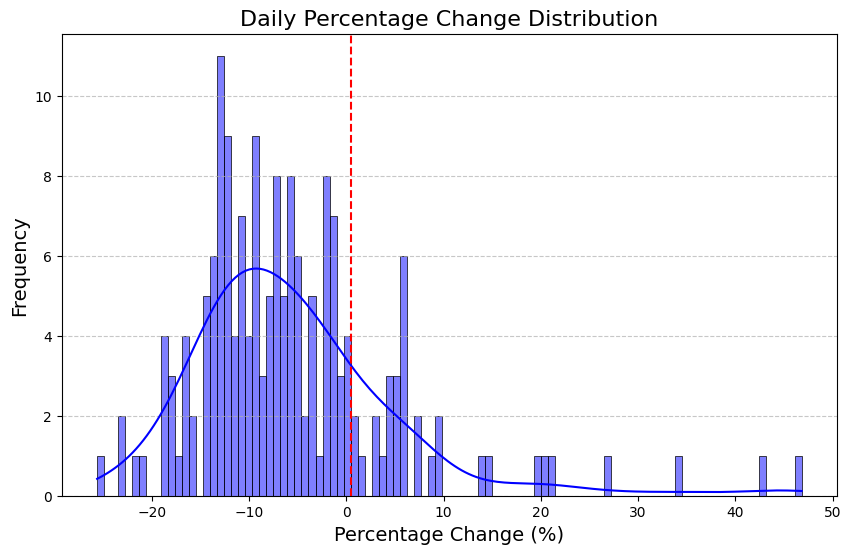

-1299.1
358.88
勝率
0.20118343195266272


In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

# 計算每日百分比變動
daylist = earn_date_list['earn_mix']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('Daily Percentage Change Distribution', fontsize=16)  # 標題
plt.xlabel('Percentage Change (%)', fontsize=14)  # x 軸標籤
plt.ylabel('Frequency', fontsize=14)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].sum())
print(daylist[daylist > 0].sum())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))


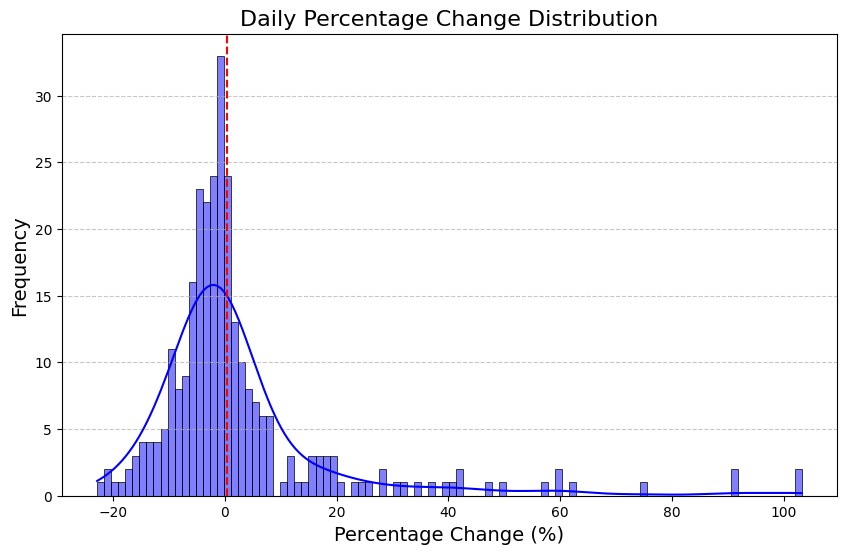

-981.86
1756.44
勝率
0.39372822299651566


In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# 計算每日百分比變動
daylist = earn_date_list['earn_mix']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('Daily Percentage Change Distribution', fontsize=16)  # 標題
plt.xlabel('Percentage Change (%)', fontsize=14)  # x 軸標籤
plt.ylabel('Frequency', fontsize=14)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist < 0].sum())
print(daylist[daylist > 0].sum())

print('勝率')

loss = len(daylist[daylist < 0])
win = len(daylist[daylist > 0])

print(win / (win + loss))


-507.37899045886473
321.86093592692623


In [ ]:
earn_date_list[earn_date_list['earn_mix'] > 30]

,證券代號,證券名稱,select_day,開盤價,收盤價,明天收盤價,明天開盤價,後天收盤價,後天開盤價,X天收盤價,...,sell_date,RS20,RS60,RS240,loss_type,GMFE,MAE,BMFE,real_hold_day,not_sl_sell_date
5,6449,鈺邦,2024-04-08,88.20,89.50,91.00,89.80,89.50,91.00,121.5,...,2024-05-08,95.583424,91.875682,88.276990,1,0,0,0,21,2024-05-08
11,6177,達麗,2024-04-08,44.30,45.35,45.30,45.40,47.25,46.95,67.0,...,2024-05-08,95.365322,94.056707,87.350055,1,0,0,0,21,2024-05-08
13,2501,國建,2024-04-08,22.10,23.70,24.90,24.25,27.35,24.90,36.0,...,2024-05-08,95.310796,92.748092,89.203926,1,0,0,0,21,2024-05-08
31,3466,德晉,2024-04-08,35.00,36.70,37.45,38.50,37.95,38.00,57.1,...,2024-05-08,99.018539,97.655398,87.186478,1,0,0,0,21,2024-05-08
33,1587,吉茂,2024-04-08,42.40,43.60,39.25,44.20,41.50,39.25,76.5,...,2024-05-08,99.727372,99.509269,97.328244,1,0,0,0,21,2024-05-08
75,3030,德律,2024-04-15,96.80,100.00,97.30,100.00,98.30,96.80,139.0,...,2024-05-15,96.237732,96.346783,93.402399,1,0,0,0,21,2024-05-15
115,1446,宏和,2024-04-29,38.05,39.35,39.80,40.05,43.75,40.30,52.0,...,2024-05-29,93.729553,84.187568,59.323882,1,0,0,0,21,2024-05-29
124,6419,京晨科,2024-05-03,73.00,75.20,72.10,74.70,79.30,72.10,145.0,...,2024-06-03,98.637602,98.038147,94.604905,1,0,0,0,21,2024-06-03
136,3564,其陽,2024-05-08,68.90,69.50,76.40,70.00,70.00,77.80,105.5,...,2024-06-06,97.983651,91.825613,89.482289,1,0,0,0,21,2024-06-06
141,2613,中櫃,2024-05-10,23.05,25.00,27.50,27.50,30.25,28.00,47.0,...,2024-06-11,95.152505,85.348584,69.825708,1,0,0,0,21,2024-06-11


回測停利不同時間下的報酬率

In [83]:
total_earn_data

,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,avg_earn_mix,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,total_earn_moeny
0,15,80,20,771.77,928.04,1.914218,844.17,1373.72,1071.22,274,-26.99,-24.88,-24.88,-35.71,-33.83,NaN
1,16,80,20,784.07,990.35,1.956864,861.02,1345.06,1248.82,283,-26.99,-24.88,-24.88,-33.62,-33.33,NaN
2,17,80,20,918.17,1034.11,2.283166,1002.31,1469.74,1265.95,296,-26.99,-24.88,-24.88,-33.99,-28.53,NaN
3,18,80,20,924.17,1186.72,2.354635,1031.33,1574.68,1422.88,306,-26.99,-24.88,-24.88,-28.94,-30.60,NaN
4,19,80,20,1009.78,1192.46,2.555149,1116.60,1661.62,1467.48,314,-26.99,-24.88,-24.88,-31.53,-35.42,NaN
5,20,80,20,986.38,1227.28,2.517963,1100.35,1676.70,1510.63,323,-26.99,-24.88,-24.88,-34.52,-35.20,NaN
6,21,80,20,951.57,1158.24,2.418970,1057.09,1577.46,1467.10,332,-26.99,-24.88,-24.88,-35.22,-33.21,NaN


In [76]:
earn_date_list[earn_date_list['earn_mix']>0]

earn_date_list[earn_date_list['earn_mix']>0]['earn_mix'].sum()

earn_date_list['earn_mix'].mean()

2.418970251716247

In [89]:
print(earn_date_list[earn_date_list['earn_mix']<0]['earn_nonsetloss_close'].sum())

print(earn_date_list[earn_date_list['earn_mix']<0]['earn_mix'].sum())

-1081.9800000000002
-1484.88


In [ ]:
# 試著將持倉調整為最多五檔
# 目前持倉
Date_list = stock_df_raw[(stock_df_raw['證券代號'] == '2330') & (stock_df_raw['Date'] >= '2021-02-17') & (stock_df_raw['Date'] <= '2024-10-23') ]['Date']

my_account_list = list(range(1, 2, 1)) 


for my_account in my_account_list:
    remaning_accout = my_account

    # 只能賣不能買
    only_sell = False


    my_stock_hold = pd.DataFrame(columns=['count','buy_date'])

    exit_stock_list  = pd.DataFrame(columns=['證券代號','證券名稱','select_day',
                                            '開盤價', '收盤價',
                                            '明天收盤價','明天開盤價',
                                            '後天收盤價','後天開盤價',
                                            'X天收盤價','earn_mix賣出價',
                                            'earn_close','earn_open','earn_mix',
                                            'earn_nonsetloss_close','earn_nonsetloss_open',
                                            'buy_date', 'sell_date',
                                            'RS20','RS60','RS240',
                                            'loss_type',
                                            'GMFE','MAE','BMFE',
                                            'real_hold_day','not_sl_sell_date',
                                            'VOL','VOL5','VOL10','VOL20','VOL60'])


    for select_day in Date_list:

        today_buy = earn_date_list[(earn_date_list['buy_date'] == select_day)  ].sort_values(by='RS20', ascending=True )  # 同一天沒關係 剛好交割起來
        # 有買才能有賣
        today_sell = exit_stock_list[(exit_stock_list['sell_date'] == select_day) ].sort_values(by='RS20')   # 同一天沒關係 剛好交割起來

        if( (len(today_buy) == 0) & (len(today_sell) == 0) ):
            continue

        # 要先賣股票
        if (only_sell) :
            
            if (len(today_sell) > 0) :
                remaning_accout = len(today_sell)
                only_sell = False
            else :
                continue
        else :

            # 如果今天要買的大於賣出的 就得動用資金
            today_need = len(today_buy) - len(today_sell)

            # 買進比賣出多 需要動用股票
            if (today_need > 0) :

                # 目前帳戶還能買幾檔
                account_need = remaning_accout - today_need

                if (account_need < 0) :
                    
                    today_stock = today_buy.head(remaning_accout)
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 
                    remaning_accout = 0

                else:
                    # 全收
                    today_stock = today_buy
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 
                    remaning_accout = account_need 

            else: 
                # 釋出資金
                remaning_accout = remaning_accout - today_need

                #如果有買進一樣全收
                if(len(today_buy) > 0) :

                    today_stock = today_buy
                    exit_stock_list = pd.concat([exit_stock_list, today_stock], ignore_index=True) 

            # 檢查目前狀況
            if (remaning_accout == 0):
                only_sell = True
            else :
                only_sell = False
                
    exit_stock_list = exit_stock_list.sort_values(by='sell_date')
    print((exit_stock_list['earn_mix']/my_account).cumsum().iloc[-1])

In [ ]:
print(len(exit_stock_list[exit_stock_list['earn_mix'] > 0]))
print(len(exit_stock_list[exit_stock_list['earn_mix'] <= 0]))

print(exit_stock_list[exit_stock_list['earn_mix'] <= 0]['earn_mix'].mean())
print(exit_stock_list[exit_stock_list['earn_mix'] > 0]['earn_mix'].mean())

In [ ]:
# remove_df  = exit_stock_list[['select_day', '證券代號']]
# # 使用 merge 並標記要移除的資料
# merged_df = earn_date_list.merge(remove_df, on=['select_day', '證券代號'], how='left', indicator=True)
# merged_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

# 其他時間補0
Date_list = stock_2330[(stock_2330['Date'] >= '2021-01-01') & (stock_2330['Date'] <= '2024-09-30')]['Date']

earn_price_list = pd.DataFrame(columns=['Date','earn_price'])

for day in Date_list:

    earn_price =  exit_stock_list[exit_stock_list['sell_date'] == day]['earn_mix'].sum()

    temp_df = pd.DataFrame({
        'Date': [day],
        'earn_price':[earn_price]
    })

    # 删除全为NA的列，避免可能出现的警告
    temp_df.dropna(axis=1, how='all', inplace=True)
    if not temp_df.empty:
        earn_price_list = pd.concat([earn_price_list, temp_df], ignore_index=True)

earn_price_list.loc[earn_price_list['earn_price'] != 0, 'earn_price'] /= 100


earn_price_list = earn_price_list.groupby('Date')['earn_price'].sum()

earn_price_list.columns = ['Date', 'earn_price']
earn_price_list = earn_price_list.to_frame(name='earn_price')
earn_price_list

earn_price_list['earn_price'] = pd.to_numeric(earn_price_list['earn_price'], errors='coerce')
import pyfolio as pf
pf.create_returns_tear_sheet( earn_price_list['earn_price'] )

In [5]:
plot_size = 100
x_lab = 2

In [28]:

import requests
from io import StringIO
import pandas as pd
import time
import json
from json import load
from bs4 import BeautifulSoup
import re

data = requests.get('https://www.twse.com.tw/exchangeReport/MI_INDEX?reponse=csv&date=20241204&type=ALLBUT0999', timeout=10)
if data.text =='':
    print('empty')
jsondata = json.loads(data.text)
if jsondata['stat'] == 'OK':
    # # 存加權指數table
    df_twse = pd.DataFrame(jsondata['tables'][0]['data']).drop(5, axis=1) 
    df_twse.columns = ['指數名稱','價格指數值','報酬指數值','漲跌點數','漲跌百分比']
    df_twse= df_twse.dropna(axis=1,how='all').dropna(axis=0,how='all')
    df_twse['Date']='20241204'
    df_twse= df_twse.apply(lambda s:s.astype(str).str.replace("<p style ='color:red'>",''))
    df_twse= df_twse.apply(lambda s:s.astype(str).str.replace("<p style ='color:green'>",''))
    df_twse= df_twse.apply(lambda s:s.astype(str).str.replace("</p>",''))
    df_twse= df_twse.apply(lambda s:s.astype(str).str.replace(',',''))

    cols_to_numeric = ['價格指數值', '漲跌點數', '漲跌百分比']
    df_twse[cols_to_numeric] = df_twse[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
    df_twse[cols_to_numeric] = df_twse[cols_to_numeric].fillna(0)

In [29]:
df_twse

,指數名稱,價格指數值,報酬指數值,漲跌點數,漲跌百分比,Date
0,寶島股價指數,26312.16,+,265.40,1.02,20241204
1,發行量加權股價指數,23255.33,+,227.87,0.99,20241204
2,臺灣公司治理100指數,13850.11,+,135.18,0.99,20241204
3,臺灣50指數,19490.28,+,219.41,1.14,20241204
4,臺灣50權重上限30%指數,16668.92,+,159.12,0.96,20241204
5,臺灣中型100指數,19736.75,+,178.69,0.91,20241204
6,臺灣資訊科技指數,38933.16,+,552.78,1.44,20241204
7,臺灣發達指數,10152.95,+,46.32,0.46,20241204
8,臺灣高股息指數,9408.20,+,27.15,0.29,20241204
9,臺灣就業99指數,13538.84,+,60.22,0.45,20241204
